从 Equinor Volve 数据读取 LAS 和 DLIS 文件

## 术语解释

1. **LAS 文件**：LAS（Log ASCII Standard）文件格式是测井数据交换的一种标准，用于存储地质测井数据。这种格式易于阅读和分享，广泛用于石油和天然气行业。

2. **DLIS 文件**：DLIS（Digital Log Interchange Standard）是另一种用于测井数据的文件格式，支持更复杂的数据类型和结构。DLIS 格式能够存储更多详细信息，适用于高级测井分析。

3. **matplotlib**：一个 Python 绘图库，提供了一个类似于 MATLAB 的绘图系统。matplotlib 可用于创建高质量的图形、图表、图等。

4. **pandas**：一个开源的 Python 数据分析库，提供高性能、易用的数据结构和数据分析工具。DataFrame 是 pandas 中用于存储表格数据的主要数据结构。

5. **合并（Merge）**：在数据处理中，合并是指将两个或多个数据集根据某些共同字段或条件组合成一个数据集的过程。

6. **深度（DEPTH）**：在测井数据中，深度是指井下特定点的垂直深度，通常是测井数据的关键索引之一。

7. **非必要列（Unwanted Columns）**：在数据清理过程中，指那些对当前分析任务不重要或无关的数据列，这些列通常会被移除以简化数据集。

8. **无穷大值（Infinity Values）**：在数据处理中，无穷大值可能因为计算或数据录入错误而出现，通常需要被处理或替换，以避免分析时的问题。

9. **VSH公式**：用于计算泥岩体积的公式，常用于测井数据分析中。

10. **密度孔隙率**：通过测量岩石密度来估计岩石中的孔隙率。

11. **孔隙率公式**：用于计算岩石孔隙率的公式，孔隙率是指岩石体积中孔隙所占的比例。

12. **SW公式**：用于计算地层水饱和度的公式，是油气藏评价的重要参数之一。

13. `pd.concat`: pandas 的连接操作 (pandas library function)

14. `inplace=True`: 修改原始 DataFrame (in-place modification)

15. `reindex`: 重新排序索引 (pandas function)

16. `np.nan`: NumPy 中表示缺失值的常量 (NumPy constant for missing values)

17. **深度** (DEPTH)： 测井点的深度。

18. **GR** (Gamma Ray)： 自然伽马曲线，反映地层放射性强弱。

19. **CALI** (Caliper)： 井径曲线，反映井眼直径变化。

20. **ROP** (Rate of Penetration)： 钻速曲线，反映钻井速度。
21. **RHOB** (Bulk Density)： 岩石密度曲线。
22. **NPHI** (Neutron Porosity)： 中子孔隙度曲线，反映地层孔隙度。
23. **RACEHM** (High-Medium Resistivity)： 高-中电阻率曲线，反映地层电阻率。
24. **RACELM** (Low-Medium Resistivity)：低-中电阻率曲线。
25. **RM** (MicroSpherically Focused Resistivity)： 微球聚焦电阻率曲线。
27. **RD** (Deep Resistivity)： 深电阻率曲线。
28. **PEF** (Photoelectric Factor)： 光电吸收系数曲线。
29. **DT** (Compressional Slowness)： 声波时差曲线，反映地层纵波速度。
30. **DTS** (Shear Slowness)： 横波时差曲线，反映地层横波速度。
31. **PHIF** (Total Porosity)： 总孔隙度曲线。
32. **VSH** (Shale Volume)： 页岩体积含量曲线。
33. **VCARB** (Carbonate Volume)： 碳酸盐体积含量曲线。
34. **SAND_FLAG**、**CARB_FLAG**、**COAL_FLAG**： 砂岩、碳酸盐岩、煤岩标志曲线。
35. **SW** (Water Saturation)： 含水饱和度曲线。
36. **KLOGH**、**KLOGV**： 水平和垂直方向渗透率曲线。


## 导入库 和 notebook 魔法命令

In [ ]:
import numpy as np
import lasio
import dlisio
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from pandas import Series, DataFrame
%matplotlib inline  
# 确保可以查看多达 100 行`rows`的 pandas 表格`tables`
pd.set_option('display.max_rows', 100)
# 完全抑制`chained indexing`链式索引警告`warnings`
pd.set_option('mode.chained_assignment', None)

# 为本文件中的所有图形设置默认 DPI。较低的 DPI 会产生较小的图形，较高的则产生较大的图形。
mpl.rcParams['figure.dpi'] = 150

## 自定义辅助函数

### 合并同一口井的测井数据

合并数据，操作数据，增加井名列

In [100]:
#函数`Merge`合并 Volve `data`数据的`Well log`测井文件并`Create`创建`new columns`井名列`well_name`。

def merge_createname(data1, data2=None, Well=None, **kwargs):
    # 基于 'DEPTH' `column`列`merge`合并两个`dataframes`数据帧
    if data2 is not None:
        dt=pd.merge_asof(data1, data2, on='DEPTH', allow_exact_matches=True)
    else:
        dt=data1
    
    # 创建井名列
    for label, value in kwargs.items():
        dt['WELL_NAME'] = Series(np.repeat(value,len(dt['DEPTH'])))
    cols = dt.columns.tolist()  # `rearrange`重新排列列，使井名列在前`first`
    cols = cols[-1:] + cols[:-1]
    dt = dt[cols]
    
    # 检查`Depth data`深度数据是否`matches`匹配由 STRT, STOP 和 STEP 值设定的`intervals`区间
    if Well is not None:
        d1=np.array(Well['DEPTH'])
        if Well.well['STEP'].value==0:
            Well.well['STEP'].value=dt['DEPTH'].diff()[1]
            d2=np.arange(Well.well['STRT'].value,Well.well['STOP'].value,Well.well['STEP'].value)
        else:
            d2=np.arange(Well.well['STRT'].value,Well.well['STOP'].value+Well.well['STEP'].value,Well.well['STEP'].value)
        if np.abs(d1-d2).sum()>1e-3:
            Well.curves['DEPTH'].data=d2
            dt['DEPTH']=d2
            
    # `Drop`删除`non-essential`非必要列
    unwanted = {'ABDCQF01', 'ABDCQF02', 'ABDCQF03', 'ABDCQF04', 'BVW', 'DRHO', 'NBGRCFM', 'DELTA',
                'GRMAX','GRMIN', 'J', 'BADDATA_FLAG', 'KLHC_INT', 'M', 'N', 'PERF_FLAG', 'PORD',
                'RHOFL', 'RHOMA', 'RW', 'SWIRR', 'RD', 'RM', 'RT', 'ROP5_RM', 'RS',
                'PHID', 'ROBB', 'ROBU', 'DRHB', 'DRHU', 'TEMP'
                }
    for column in dt.columns:
        if column in unwanted:
            dt.drop(column, axis=1, inplace=True)
            
    # 将所有`infinity values`无穷大值`replacing`替换为 NAN
    dt.replace([np.inf, -np.inf], np.nan, inplace = True)

    return dt

## 加载数据

### 加载 LAS 文件

In [ ]:
#%% 加载LAS数据集

fname = './LAS_FILES/15_9-19_A_CPI.las'
Well_F19A = lasio.read(fname)
dataF19A=DataFrame(Well_F19A.data, columns=list(Well_F19A.curvesdict.keys()))
# 根据VSH公式计算GR
dataF19A['GR'] = dataF19A['GRMAX'] - dataF19A['VSH']*(dataF19A['GRMAX']-dataF19A['GRMIN'])
# 根据`Density porosity`密度孔隙率公式计算RHOB
dataF19A['RHOB'] = dataF19A['RHOMA'] - dataF19A['PORD']*(dataF19A['RHOMA']-dataF19A['RHOFL'])
# 根据`porosity`孔隙率公式计算NPHI
dataF19A['NPHI'] = dataF19A['PORD'] + (dataF19A['PHIF']-dataF19A['PORD']-0.01)/0.4
dataF19A['NPHI'] = dataF19A['NPHI'].abs()   
# 根据SW公式计算RT
dataF19A['RPCEHM'] = dataF19A['RW']/(dataF19A['SW']**(-1/dataF19A['N']) * (dataF19A['PHIF']+0.01)**(dataF19A['M']))
dataF19A = merge_createname(dataF19A, None, Well_F19A, name='Well_F19A')
del Well_F19A
# 保留至少有6个非NaN值的行
dataF19A.dropna(thresh=6,inplace=True)

fname = './LAS_FILES/15_9-19_BT2_CPI.las'
Well_F19BT2 = lasio.read(fname)
dataF19BT2=DataFrame(Well_F19BT2.data, columns=list(Well_F19BT2.curvesdict.keys()))
#calculate RT from  SW formula
dataF19BT2['RPCEHM'] = dataF19BT2['RW']/(dataF19BT2['SW']**(-1/2.45) * dataF19BT2['PHIF']**1.79)
dataF19BT2 = merge_createname(dataF19BT2, None, Well_F19BT2, name='Well_F19BT2')
del Well_F19BT2
#Keep any rows with 5 and more non-nan values
dataF19BT2.dropna(thresh=5,inplace=True)

fname = './LAS_FILES/15_9-19_SR_CPI.las'
Well_F19SR = lasio.read(fname)
dataF19SR=DataFrame(Well_F19SR.data, columns=list(Well_F19SR.curvesdict.keys()))
dataF19SR = merge_createname(dataF19SR, None, Well_F19SR, name='Well_F19SR')
del Well_F19SR
#Keep any rows with 4 and more non-nan values
dataF19SR.dropna(thresh=4,inplace=True)

fname = './LAS_FILES/15_9-F-1_A_CPO.las'
Well_F1A = lasio.read(fname)
dataF1AO=DataFrame(Well_F1A.data, columns=list(Well_F1A.curvesdict.keys()))
fname = './LAS_FILES/15_9-F-1_A_CPI.las'
Well_F1A = lasio.read(fname)
dataF1A=DataFrame(Well_F1A.data, columns=list(Well_F1A.curvesdict.keys()))
dataF1A = merge_createname(dataF1A, dataF1AO, Well_F1A, name='Well_F1A')
del Well_F1A; del dataF1AO
#Keep any rows with 7 and more non-nan values
dataF1A.dropna(thresh=7,inplace=True)

fname = './LAS_FILES/15_9-F-1_B_CPO.las'
Well_F1B = lasio.read(fname)
dataF1BO=DataFrame(Well_F1B.data, columns=list(Well_F1B.curvesdict.keys()))
fname = './LAS_FILES/15_9-F-1_B_CPI.las'
Well_F1B = lasio.read(fname)
dataF1B=DataFrame(Well_F1B.data, columns=list(Well_F1B.curvesdict.keys()))
dataF1B = merge_createname(dataF1B, dataF1BO, Well_F1B, name='Well_F1B')
del Well_F1B; del dataF1BO
#Keep any rows with 7 and more non-nan values
dataF1B.dropna(thresh=7,inplace=True)

fname = './LAS_FILES/15_9-F-1_C_CPO.las'
Well_F1C = lasio.read(fname)
dataF1CO=DataFrame(Well_F1C.data, columns=list(Well_F1C.curvesdict.keys()))
#Drop bad data
dataF1CO=dataF1CO[dataF1CO['BADDATA_FLAG'] != 1]
fname = './LAS_FILES/15_9-F-1_C_CPI.las'
Well_F1C = lasio.read(fname)
dataF1C=DataFrame(Well_F1C.data, columns=list(Well_F1C.curvesdict.keys()))
dataF1C = merge_createname(dataF1C, dataF1CO, Well_F1C, name='Well_F1C')
del Well_F1C; del dataF1CO
#Keep any rows with 7 and more non-nan values
dataF1C.dropna(thresh=7,inplace=True)

fname = './LAS_FILES/15_9-F-1_CPO.las'
Well_F1 = lasio.read(fname)
dataF1O=DataFrame(Well_F1.data, columns=list(Well_F1.curvesdict.keys()))
fname = './LAS_FILES/15_9-F-1_CPI.las'
Well_F1 = lasio.read(fname)
dataF1=DataFrame(Well_F1.data, columns=list(Well_F1.curvesdict.keys()))
dataF1 = merge_createname(dataF1, dataF1O, Well_F1, name='Well_F1')
del Well_F1; del dataF1O
#Keep any rows with 7 and more non-nan values
dataF1.dropna(thresh=7,inplace=True)

fname = './LAS_FILES/15_9-F-11_A_CPO.las'
Well_F11A = lasio.read(fname)
dataF11AO=DataFrame(Well_F11A.data, columns=list(Well_F11A.curvesdict.keys()))
fname = './LAS_FILES/15_9-F-11_A_CPI.las'
Well_F11A = lasio.read(fname)
dataF11A=DataFrame(Well_F11A.data, columns=list(Well_F11A.curvesdict.keys()))
dataF11A = merge_createname(dataF11A, dataF11AO, Well_F11A, name='Well_F11A')
del Well_F11A; del dataF11AO
#Keep any rows with 7 and more non-nan values
dataF11A.dropna(thresh=7,inplace=True)

fname = './LAS_FILES/15_9-F-11_B_CPO.las'
Well_F11B = lasio.read(fname)
dataF11BO=DataFrame(Well_F11B.data, columns=list(Well_F11B.curvesdict.keys()))
fname = './LAS_FILES/15_9-F-11_B_CPI.las'
Well_F11B = lasio.read(fname)
dataF11B=DataFrame(Well_F11B.data, columns=list(Well_F11B.curvesdict.keys()))
dataF11B = merge_createname(dataF11B, dataF11BO, Well_F11B, name='Well_F11B')
del Well_F11B; del dataF11BO
#Keep any rows with 7 and more non-nan values
dataF11B.dropna(thresh=7,inplace=True)

fname = './LAS_FILES/15_9-F-11_CPI.las'
Well_F11 = lasio.read(fname)
dataF11=DataFrame(Well_F11.data, columns=list(Well_F11.curvesdict.keys()))
dataF11 = merge_createname(dataF11, None, Well_F11, name='Well_F11')
del Well_F11
#Keep any rows with 4 and more non-nan values
dataF11.dropna(thresh=4,inplace=True)

fname = './LAS_FILES/15_9-F-11_T2_CPO.las'
Well_F11T2 = lasio.read(fname)
dataF11T2O=DataFrame(Well_F11T2.data, columns=list(Well_F11T2.curvesdict.keys()))
fname = './LAS_FILES/15_9-F-11_T2_CPI.las'
Well_F11T2 = lasio.read(fname)
dataF11T2=DataFrame(Well_F11T2.data, columns=list(Well_F11T2.curvesdict.keys()))
dataF11T2 = merge_createname(dataF11T2, dataF11T2O, Well_F11T2, name='Well_F11T2')
del Well_F11T2; del dataF11T2O
#Keep any rows with 7 and more non-nan values
dataF11T2.dropna(thresh=7,inplace=True)

fname = './LAS_FILES/15_9-F-12_CPO.las'
Well_F12 = lasio.read(fname)
dataF12O=DataFrame(Well_F12.data, columns=list(Well_F12.curvesdict.keys()))
#adjust Resistivity naming to fit the rest above
dataF12O.rename(columns = {'RT':'RPCEHM','RD':'RPCELM'}, inplace=True)
fname = './LAS_FILES/15_9-F-12_CPI.las'
Well_F12 = lasio.read(fname)
dataF12=DataFrame(Well_F12.data, columns=list(Well_F12.curvesdict.keys()))
dataF12 = merge_createname(dataF12, dataF12O, Well_F12, name='Well_F12')
del Well_F12; del dataF12O
#Keep any rows with 7 and more non-nan values
dataF12.dropna(thresh=7,inplace=True)

fname = './LAS_FILES/15_9-F-15D_CPO.las'
Well_F15D = lasio.read(fname)
dataF15DO=DataFrame(Well_F15D.data, columns=list(Well_F15D.curvesdict.keys()))
fname = './LAS_FILES/15_9-F-15D_CPI.las'
Well_F15D = lasio.read(fname)
dataF15D=DataFrame(Well_F15D.data, columns=list(Well_F15D.curvesdict.keys()))
dataF15D = merge_createname(dataF15D, dataF15DO, Well_F15D, name='Well_F15D')
del Well_F15D; del dataF15DO
#Keep any rows with 8 and more non-nan values
dataF15D.dropna(thresh=8,inplace=True)

观察数据

In [ ]:
# 打印出样本测井数据
print(dataF15D)

### 加载 DLTS 文件

In [102]:
#%%加载 DLIS 数据集的函数

def extract_data(fname):
    """
    从 DLIS 文件中提取数据

    参数:
        fname (str): DLIS 文件路径

    返回:
        pandas.DataFrame: 提取后的数据，列名对应原始数据中的曲线名称
    """
    f, *f_tail = dlisio.load(fname)
    #print(f.describe())
    
    logname=[x for x in f.channels]
    name=[]
    for line in logname:
        w = str(line).strip(')').split('(')
        name.append(w[1])
        
    combined = []
    for n in name:
        frame = f.object('channel', '%s' % n)
        curve = frame.curves()
        # Convert the index to metres if needed
        if n == 'DEPTH' and frame.units == '0.1 in':
            curve = curve *0.00254
        combined.append(curve)
    data = DataFrame(combined).T
    data.columns = name
    return data

加载多个 DLIS 地层数据文件，并对数据进行必要的处理。

1. 定义函数 `extract_data`，用于从 DLIS 文件中提取数据并转换为 DataFrame 格式。
2. 多个 DLIS 文件名，依次调用 `extract_data` 函数读取数据。
3. 对于部分文件，调整电阻率列名以保持一致性 ("RT" 改为 "RPCEHM"，"RD" 改为 "RPCELM")。
4. 某些文件可能存在额外的列，需要进行删除 ("RHOB" 列)。
5. 将每个 DLIS 文件的两个部分数据 (CPI 和 CPO) 合并成一个 DataFrame，并创建井名列。
6. 删除临时变量 (以 "O" 结尾的 DataFrame)。


In [ ]:
#%%Loading DLIS Dataset
fname = './LAS_FILES/15_9-F-4_CPI.DLIS'
dataF4=extract_data(fname)
#adjust Resistivity naming to fit the rest above
dataF4.rename(columns = {'RT':'RPCEHM','RD':'RPCELM'}, inplace=True)
fname = './LAS_FILES/15_9-F-4_CPO.DLIS'
dataF4O=extract_data(fname)
dataF4 = merge_createname(dataF4, dataF4O, name='Well_F4')
del dataF4O

fname = './LAS_FILES/15_9-F-5_CPI.DLIS'
dataF5=extract_data(fname)
#adjust Resistivity naming to fit the rest above
dataF5.rename(columns = {'RT':'RPCEHM','RD':'RPCELM'}, inplace=True)
fname = './LAS_FILES/15_9-F-5_CPO.DLIS'
dataF5O=extract_data(fname)
dataF5 = merge_createname(dataF5, dataF5O, name='Well_F5')
del dataF5O

fname = './LAS_FILES/15_9-F-10_CPI.DLIS'
dataF10=extract_data(fname)
#adjust Resistivity naming to fit the rest above
dataF10.rename(columns = {'RT':'RPCEHM','RD':'RPCELM'}, inplace=True)
fname = './LAS_FILES/15_9-F-10_CPO.DLIS'
dataF10O=extract_data(fname)
dataF10O.drop(['RHOB'], axis=1, inplace=True)
dataF10 = merge_createname(dataF10, dataF10O, name='Well_F10')
del dataF10O

fname = './LAS_FILES/15_9-F-14_CPI.DLIS'
dataF14=extract_data(fname)
#adjust Resistivity naming to fit the rest above
dataF14.rename(columns = {'RT':'RPCEHM','RD':'RPCELM'}, inplace=True)
fname = './LAS_FILES/15_9-F-14_CPO.DLIS'
dataF14O=extract_data(fname)
dataF14 = merge_createname(dataF14, dataF14O, name='Well_F14')
del dataF14O

fname = './LAS_FILES/15_9-F-15_CPI.DLIS'
dataF15=extract_data(fname)
#adjust Resistivity naming to fit the rest above
dataF15.rename(columns = {'RT':'RPCEHM','RD':'RPCELM'}, inplace=True)
fname = './LAS_FILES/15_9-F-15_CPO.DLIS'
dataF15O=extract_data(fname)
dataF15 = merge_createname(dataF15, dataF15O, name='Well_F15')
del dataF15O

fname = './LAS_FILES/15_9-F-15A_CPI.DLIS'
dataF15A=extract_data(fname)
#adjust Resistivity naming to fit the rest above
dataF15A.rename(columns = {'RT':'RPCEHM','RD':'RPCELM'}, inplace=True)
fname = './LAS_FILES/15_9-F-15A_CPO.DLIS'
dataF15AO=extract_data(fname)
dataF15A = merge_createname(dataF15A, dataF15AO, name='Well_F15A')
del dataF15AO

fname = './LAS_FILES/15_9-F-15B_CPI.DLIS'
dataF15B=extract_data(fname)
#adjust Resistivity naming to fit the rest above
dataF15B.rename(columns = {'RT':'RPCEHM','RD':'RPCELM'}, inplace=True)
fname = './LAS_FILES/15_9-F-15B_CPO.DLIS'
dataF15BO=extract_data(fname)
dataF15B = merge_createname(dataF15B, dataF15BO, name='Well_F15B')
del dataF15BO

fname = './LAS_FILES/15_9-F-15C_CPI.DLIS'
dataF15C=extract_data(fname)
#adjust Resistivity naming to fit the rest above
dataF15C.rename(columns = {'RT':'RPCEHM','RD':'RPCELM'}, inplace=True)
fname = './LAS_FILES/15_9-F-15C_CPO.DLIS'
dataF15CO=extract_data(fname)
dataF15C = merge_createname(dataF15C, dataF15CO, name='Well_F15C')
del dataF15CO

In [ ]:
# print out sample well log
print(dataF15C)

### 合并所有 LAS 和 DLIS 数据

In [48]:
#%% `group`合并所有数据集

# 使用 pd.concat 函数将多个 DataFrame 合并成一个
data_final = pd.concat([dataF19A, dataF19BT2, dataF19SR, dataF1A, dataF1B, dataF1C, dataF1, dataF4,
                        dataF5, dataF10, dataF11A, dataF11B, dataF11, dataF11T2, dataF12, dataF14,
                        dataF15, dataF15A, dataF15B, dataF15C, dataF15D], sort=False)
# 统一电阻率列名
data_final.rename(columns = {'RPCEHM':'RM','RPCELM':'RD'}, inplace=True)
# 重新排序列
data_final = data_final.reindex(columns=['WELL_NAME', 'DEPTH', 'GR', 'BS', 'CALI', 'ROP', 'RHOB',
                                         'NPHI', 'RACEHM', 'RACELM', 'RM', 'RD', 'PEF', 'DT', 'DTS',
                                         'VCARB', 'VSH', 'PHIF', 'SW', 'KLOGH', 'KLOGV', 'SAND_FLAG',
                                         'CARB_FLAG', 'COAL_FLAG'])

# `delete`删除`out of range`异常值
data_final.loc[:,'NPHI'][data_final.loc[:,'NPHI']>0.6]=np.nan # # NPHI 大于 0.6 的值置为空值
data_final.loc[:,'NPHI'][data_final.loc[:,'NPHI']<-0.15]=np.nan
data_final.loc[:,'VSH'][data_final.loc[:,'VSH']<0]=np.nan
data_final.loc[:,'VSH'][data_final.loc[:,'VSH']>1]=np.nan
data_final.loc[:,'SW'][data_final.loc[:,'SW']<0]=np.nan
data_final.loc[:,'SW'][data_final.loc[:,'SW']>1]=np.nan
data_final.loc[:,'PHIF'][data_final.loc[:,'PHIF']>1.0]=np.nan
data_final.loc[:,'PHIF'][data_final.loc[:,'PHIF']<0.0]=np.nan

## 可视化

### 自定义绘图函数

**函数名称：** `well_log_plot`

**功能：** 绘制多条测井曲线，以可视化地质和岩石物理特性。

**参数：**

- `well_logs`：包含测井数据的 DataFrame，必须包含 DEPTH、GR、CALI、ROP、RHOB、NPHI、RACEHM、RACELM、RM、RD、PEF、DT、DTS、PHIF、VSH、VCARB、SAND_FLAG、CARB_FLAG、COAL_FLAG、SW、KLOGH 和 KLOGV 列。
- `depths`（可选）：要绘制的深度范围，默认为所有深度。
- `savefig`（可选）：保存图像的文件名，默认不保存。

**主要步骤：**

1. **排序和处理数据：**
   - 按深度排序测井数据。
   - 处理深度范围设置。

2. **创建图形框架：**
   - 创建一个 7 列的子图布局。
   - 设置标题并调整布局。

3. **绘制各条测井曲线：**
   - 在每个子图中绘制多条测井曲线，使用不同颜色区分。
   - 设置标签、刻度、范围等属性。
   - 使用 `twiny` 函数在相同的深度轴上叠加多条曲线。
   - 为部分曲线添加填充区域（例如 VSH、VCARB、SW）。

4. **保存图像（可选）：**
   - 如果指定了文件名，将图像保存为文件。




In [95]:
#%% Plotting function
def well_log_plot (well_logs,**kwargs):
    # Sort well_logs by depth
    well_logs = well_logs.sort_values(by='DEPTH')
    dtop=well_logs.DEPTH.min(); dbot=well_logs.DEPTH.max()
    depths=kwargs.setdefault('depths',[dtop,dbot])
    savefile=kwargs.setdefault('savefig',"")
    if depths[0] in ['TOP','topfm'] or depths[-1] in ['BOTTOM','bottomfm']:
        if well_logs.PHIF.isnull().sum()!=len(well_logs):
            depths[0]=well_logs.DEPTH[well_logs.PHIF.first_valid_index()]  #make the first non-NA/null value in PHIF column
            if depths[0]>=dbot:
                depths[0]=dtop
            if well_logs.DEPTH[well_logs.PHIF.last_valid_index()] < dbot:
                depths[-1]=dbot
            else:
                depths[-1]=well_logs.DEPTH[well_logs.PHIF.last_valid_index()]
        else:
            depths[0]=dtop
            depths[-1]=dbot
    elif depths[-1]>dbot:
        depths[-1]=dbot
    elif depths[0]<dtop:
        depths[0]=dtop
    fig, axs = plt.subplots(nrows=1, ncols=7, sharey=True, squeeze=True, figsize=(15, 10), gridspec_kw={'wspace': 0.25})
    fig.subplots_adjust(left=0.05, bottom=0.05, right=0.975, top=0.7, wspace=0.2, hspace=0.2)
    axs[0].set_ylabel('Depth (m)')
    for ax in axs:
        ax.set_ylim(depths[0],depths[-1])
        ax.invert_yaxis()
        ax.grid(True)
        ax.locator_params(axis='x', nbins=5)
        ax.get_xaxis().set_visible(False)
    
    # First track GR/CALI/ROP logs to display
    ax1 = axs[0].twiny()  
    ax1.plot(well_logs.GR, well_logs.DEPTH, '-', color='olive')
    ax1.set_xlim(0,150) 
    ax1.set_xlabel('GR (API)', color='olive')
    ax1.minorticks_on()
    ax1.tick_params(axis='x', color='olive')
    ax1.spines['top'].set_position(("axes", 1.15)) # Move the last y-axis spine over to the top by 20% of the width of the axes

    ax2 = axs[0].twiny() 
    ax2.plot(well_logs.CALI, well_logs.DEPTH, '-', color='magenta')
    ax2.set_xlim(0,13) 
    ax2.set_xlabel('CALI (In)', color='magenta')
    ax2.minorticks_on()
    ax2.tick_params(axis='x', color='magenta')
    ax2.spines['top'].set_position(("axes", 1.075))
        
    ax3 = axs[0].twiny()  
    ax3.plot(well_logs.ROP, well_logs.DEPTH, '-', color='slateblue')
    ax3.set_xlim(100,0) 
    ax3.set_xlabel('ROP (m/hr)', color='slateblue')
    ax3.minorticks_on()
    ax3.tick_params(axis='x', color='slateblue')
    ax3.spines['top'].set_position(("axes", 1.0))

    # Second track NPHI/RHOB logs to display
    ax1 = axs[1].twiny()  
    ax1.plot(well_logs.RHOB, well_logs.DEPTH, '-', color='blue')
    ax1.set_xlim(1.5,3) 
    ax1.set_xlabel('RHOB (g/cm3)', color='blue')
    ax1.tick_params(axis='x', colors='blue')
    ax1.minorticks_on()
    ax1.spines['top'].set_position(("axes", 1.075))

    ax2 = axs[1].twiny()  
    ax2.plot(well_logs.NPHI, well_logs.DEPTH, '-', color='forestgreen')
    ax2.set_xlim(0.6,-0.1) 
    ax2.set_xlabel('NPHI (v/v)', color='forestgreen')
    ax2.tick_params(axis='x', color='forestgreen')
    ax2.minorticks_on()
    ax2.spines['top'].set_position(("axes", 1.0))
    
    # Third track Resistivity logs to display
    ax1 = axs[2].twiny()  
    ax1.plot(well_logs.RACEHM, well_logs.DEPTH, '-', color='lime')
    ax1.grid(True)
    ax1.set_xlim(0.1,2000)  
    ax1.set_xlabel('RACEHM (ohm.m)', color='lime')
    ax1.tick_params(axis='x', color='lime')
    ax1.set_xscale('log')
    ax1.minorticks_on()
    ax1.spines['top'].set_position(("axes", 1.075))

    ax2 = axs[2].twiny()  
    ax2.plot(well_logs.RACELM, well_logs.DEPTH, '-', color='darkviolet')
    ax2.set_xlim(0.1,2000) 
    ax2.set_xlabel('RACELM (ohm.m)', color='darkviolet')
    ax2.tick_params(axis='x', colors='darkviolet')
    ax2.set_xscale('log')
    ax2.minorticks_on()
    ax2.spines['top'].set_position(("axes", 1.15))

    ax3 = axs[2].twiny()  
    ax3.plot(well_logs.RM, well_logs.DEPTH, '-', color='darkblue')
    ax3.set_xlim(0.1,2000)  
    ax3.set_xlabel('RM (ohm.m)', color='darkblue')
    ax3.tick_params(axis='x', color='darkblue')
    ax3.set_xscale('log')
    ax3.minorticks_on()
    ax3.spines['top'].set_position(("axes", 1.225))

    ax4 = axs[2].twiny()  
    ax4.plot(well_logs.RD, well_logs.DEPTH, '-', color='cyan')
    ax4.set_xlim(0.1,2000) 
    ax4.set_xlabel('RD (ohm.m)', color='cyan')
    ax4.tick_params(axis='x', color='cyan')
    ax4.set_xscale('log')
    ax4.minorticks_on()
    ax4.spines['top'].set_position(("axes", 1.0))

    # Forth track DTC/DTS/PEF logs to display
    ax1 = axs[3].twiny()  
    ax1.plot(well_logs.PEF, well_logs.DEPTH, '-', color='grey')
    ax1.set_xlim(15,0) 
    ax1.set_xlabel('PE (b/elec)', color='grey')
    ax1.tick_params(axis='x', color='grey')
    ax1.minorticks_on()
    ax1.spines['top'].set_position(("axes", 1.0))

    ax2 = axs[3].twiny()  
    ax2.plot(well_logs.DT, well_logs.DEPTH, '-', color='orange')
    ax2.set_xlim(140,40) 
    ax2.set_xlabel('DT (us/ft)', color='orange')
    ax2.tick_params(axis='x', colors='orange')
    ax2.minorticks_on()
    ax2.spines['top'].set_position(("axes", 1.15))

    ax3 = axs[3].twiny()  
    ax3.plot(well_logs.DTS, well_logs.DEPTH, '-', color='red')
    ax3.set_xlim(240,40) 
    ax3.set_xlabel('DTS (us/ft)', color='red')
    ax3.tick_params(axis='x', color='red')
    ax3.minorticks_on()
    ax3.spines['top'].set_position(("axes", 1.075))

    # Fifth track PHIF logs to display
    ax1 = axs[4].twiny()  
    ax1.plot(well_logs.PHIF, well_logs.DEPTH, '-', color='peru')
    ax1.set_xlim(0,0.5) 
    ax1.grid(True)
    ax1.set_xlabel('PHIF (v/v)', color='peru')
    ax1.tick_params(axis='x', color='peru')
    ax1.minorticks_on()
    ax1.spines['top'].set_position(("axes", 1.225))

    ax2 = axs[4].twiny()  
    ax2.plot(well_logs.VSH, well_logs.DEPTH, '-', color='palegoldenrod')
    ax2.set_xlim(1.5,0) 
    ax2.set_xlabel('VSH', color='palegoldenrod')
    ax2.tick_params(axis='x', color='palegoldenrod')
    ax2.minorticks_on()
    ax2.spines['top'].set_position(("axes", 1.15))
    ax2.fill_betweenx(well_logs.DEPTH, well_logs.VSH, 0, where=(well_logs.VSH > 0), color='palegoldenrod', alpha=0.2)

    ax4 = axs[4].twiny()  
    ax4.plot(well_logs.VCARB, well_logs.DEPTH, '-', color='olivedrab')
    ax4.set_xlim(1.5,0) 
    ax4.set_xlabel('VCARB', color='olivedrab')
    ax4.tick_params(axis='x', color='olivedrab')
    ax4.minorticks_on()
    ax4.spines['top'].set_position(("axes", 1.075))
    ax4.fill_betweenx(well_logs.DEPTH, well_logs.VCARB, 0, where=(well_logs.VCARB > 0), color='olivedrab', alpha=0.2)

    ax3 = axs[4].twiny()  
    ax3.fill_betweenx(well_logs.DEPTH, well_logs.SAND_FLAG, 0, where=(well_logs.SAND_FLAG > 0), color='red')
    ax3.fill_betweenx(well_logs.DEPTH, well_logs.CARB_FLAG, 0, where=(well_logs.CARB_FLAG > 0), color='lime')
    ax3.fill_betweenx(well_logs.DEPTH, well_logs.COAL_FLAG, 0, where=(well_logs.COAL_FLAG > 0), color='black')
    ax3.set_xlim(10,0) 
    ax3.set_xlabel('FLAG-SAND|CARB')
    ax3.tick_params(axis='x')
    ax3.minorticks_on()
    ax3.spines['top'].set_position(("axes", 1.0))

    # Sixth track SW logs to display
    ax1 = axs[5].twiny()  
    ax1.plot(well_logs.SW, well_logs.DEPTH, '-', color='royalblue')
    ax1.grid(True)
    ax1.set_xlim(0,1) 
    ax1.set_xlabel('SW (v/v)', color='royalblue')
    ax1.tick_params(axis='x', color='royalblue')
    ax1.minorticks_on()
    ax1.spines['top'].set_position(("axes", 1.0))
    ax1.fill_betweenx(well_logs.DEPTH, well_logs.SW, 1, where=(1 >= well_logs.SW), color='green', alpha=0.5)

    # Seventh track KLOGH/KLOGV logs to display
    ax1 = axs[6].twiny()  
    ax1.set_xscale('log')
    ax1.grid(True)
    ax1.plot(well_logs.KLOGH, well_logs.DEPTH, '-', color='steelblue')
    ax1.set_xlim(0.01,10000) 
    ax1.set_xlabel('KLOGH (mD)', color='steelblue')
    ax1.tick_params(axis='x', color='steelblue')
    ax1.minorticks_on()
    ax1.spines['top'].set_position(("axes", 1.075))

    ax2 = axs[6].twiny()
    ax2.set_xscale('log')
    ax2.plot(well_logs.KLOGV, well_logs.DEPTH, '-', color='maroon')
    ax2.set_xlim(0.01,10000) 
    ax2.set_xlabel('KLOGV (mD)', color='maroon')
    ax2.tick_params(axis='x', color='maroon')
    ax2.minorticks_on()
    ax2.spines['top'].set_position(("axes", 1.0))
           
    fig.suptitle('Log Petrophysical display for %s' % well_logs.iloc[0]['WELL_NAME'],weight='bold', fontsize=20, y=0.925)
    if len(savefile)>0:
        fig.savefig(savefile,dpi=300)

### 绘图示例

使用前面所加载的所有数据

基础统计分析，打印井的名称和数量

In [57]:
n_wells=data_final['WELL_NAME'].unique()
print(n_wells)
len(n_wells)

['Well_F19A' 'Well_F19BT2' 'Well_F19SR' 'Well_F1A' 'Well_F1B' 'Well_F1C'
 'Well_F1' 'Well_F4' 'Well_F5' 'Well_F10' 'Well_F11A' 'Well_F11B'
 'Well_F11' 'Well_F11T2' 'Well_F12' 'Well_F14' 'Well_F15' 'Well_F15A'
 'Well_F15B' 'Well_F15C' 'Well_F15D']


21


生成前三个井的井筒测井图

1. **循环遍历前 3 个井名：**
   - 使用 `for` 循环语句遍历 `n_wells` 列表的前 3 个元素 (使用切片 `[:3]`)，依次取出井名。

2. **筛选对应井名的测井数据：**
   - 使用布尔索引 (`data_final['WELL_NAME'] == well`) 筛选出 `data_final` DataFrame 中与当前井名 (`well`) 匹配的子集，存储在 `well_data` 变量中。

3. **绘制井筒测井图：**
   - 调用 `well_log_plot` 函数，将筛选出的 `well_data` 作为参数传入。
   - 设置 `depths` 参数为 `['TOP', 'BOTTOM']`，表示使用全部深度范围来绘制图像。

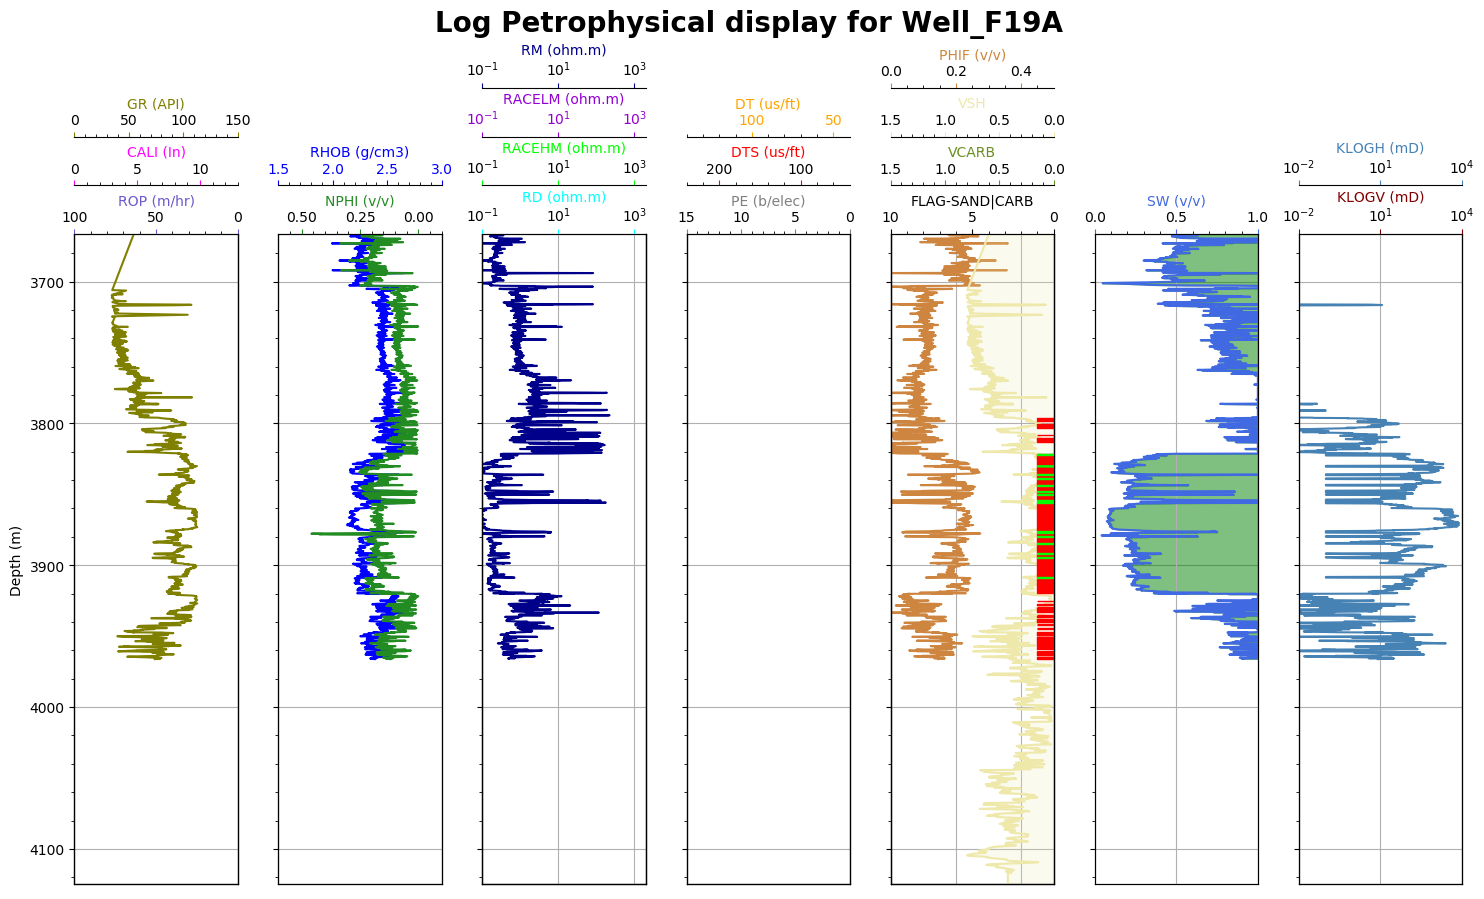

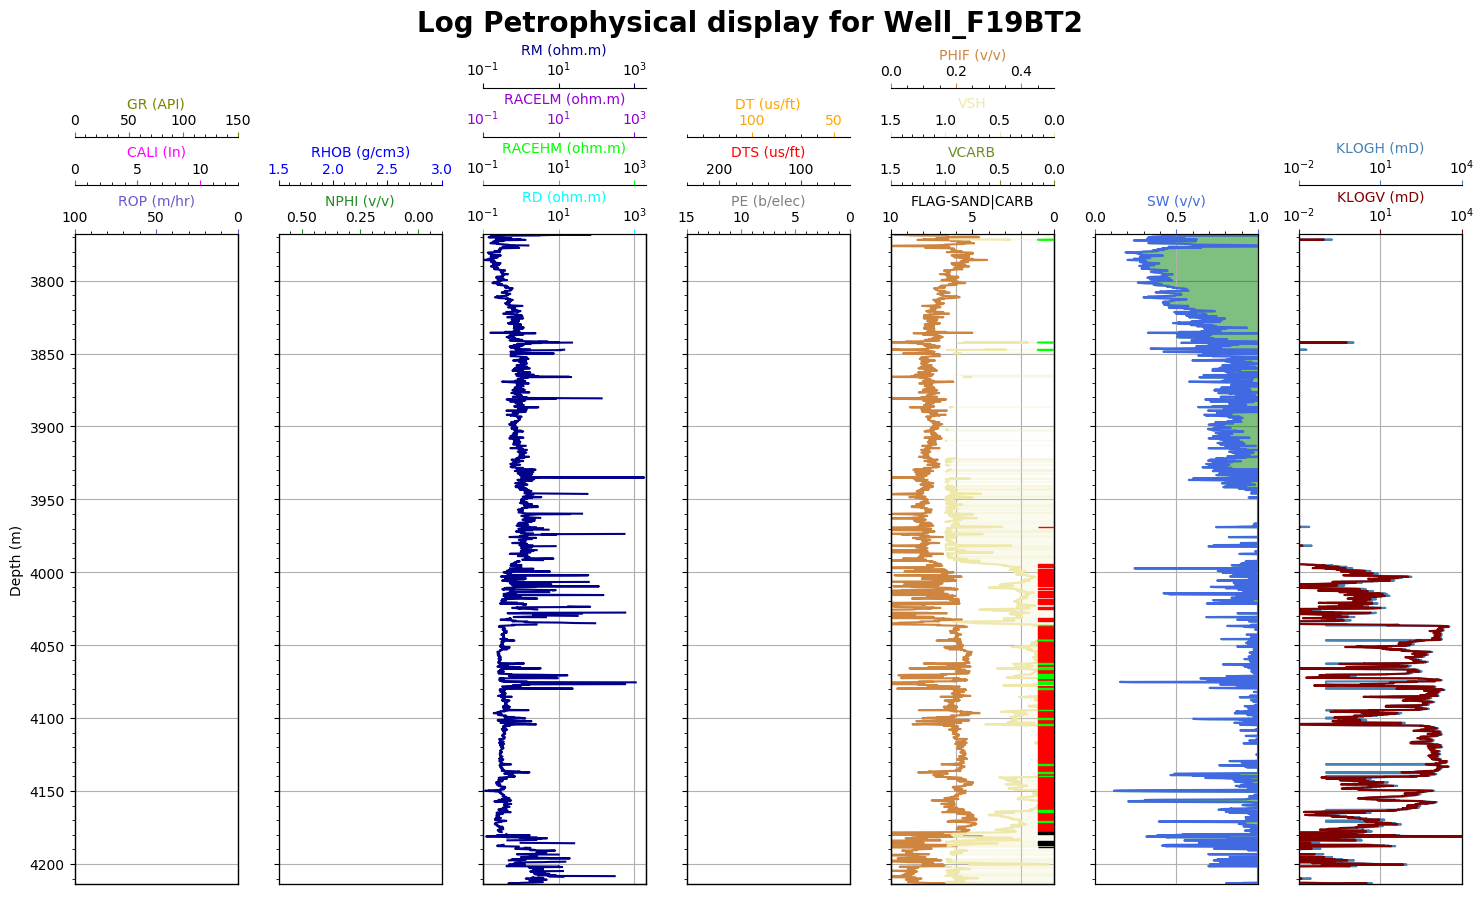

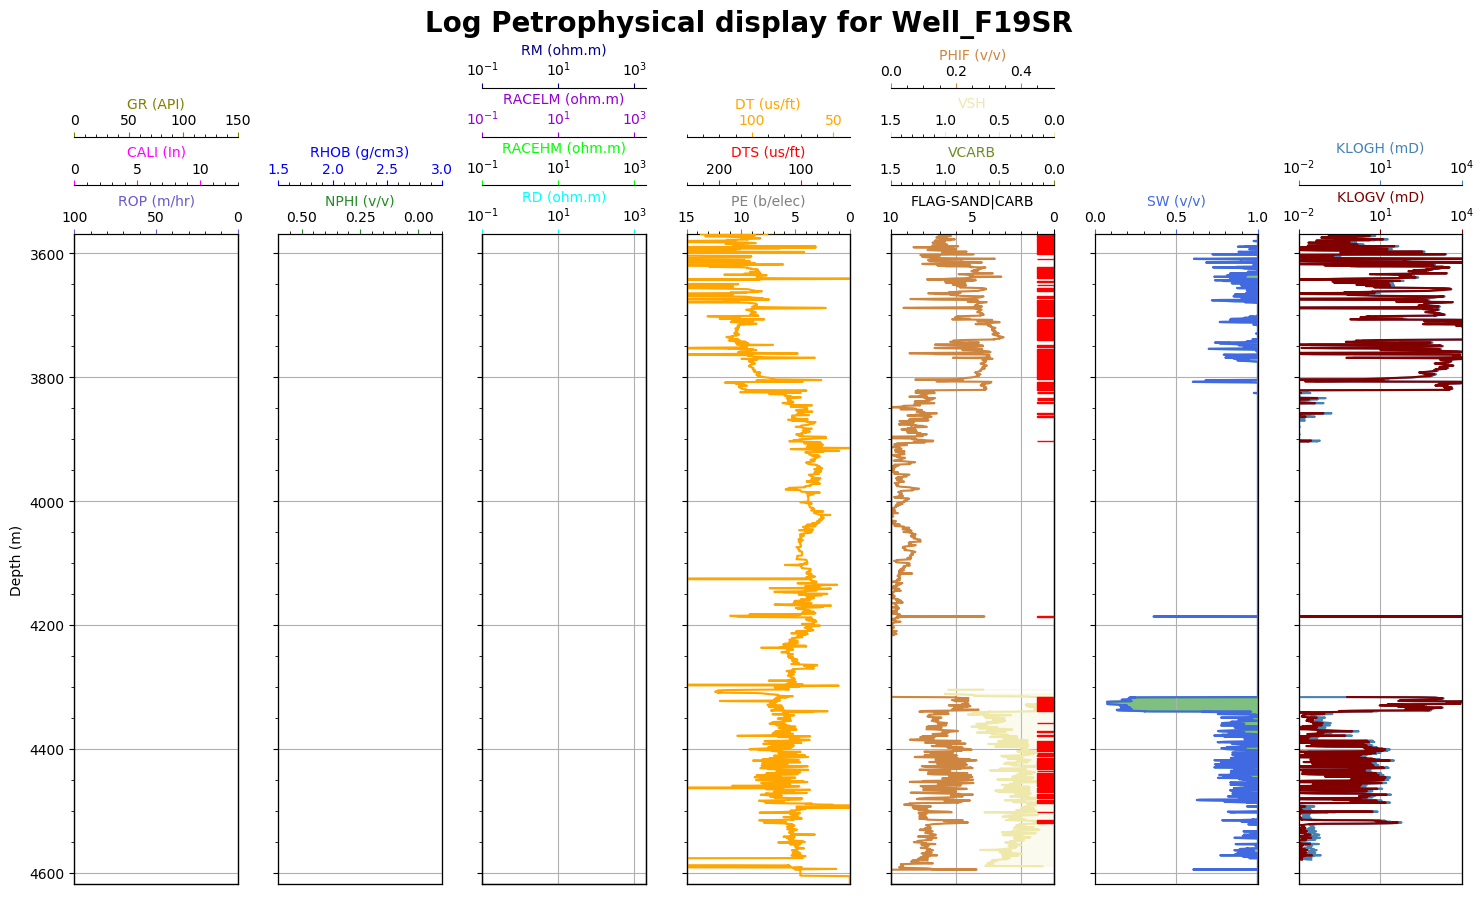

In [59]:
# generate plots for first three wells

for well in n_wells[:3]:
    well_name=data_final[data_final['WELL_NAME'] == '%s' % well]
    well_log_plot (well_name,depths=['TOP','BOTTOM'])

继续后续的三个井的绘制，可视化工作

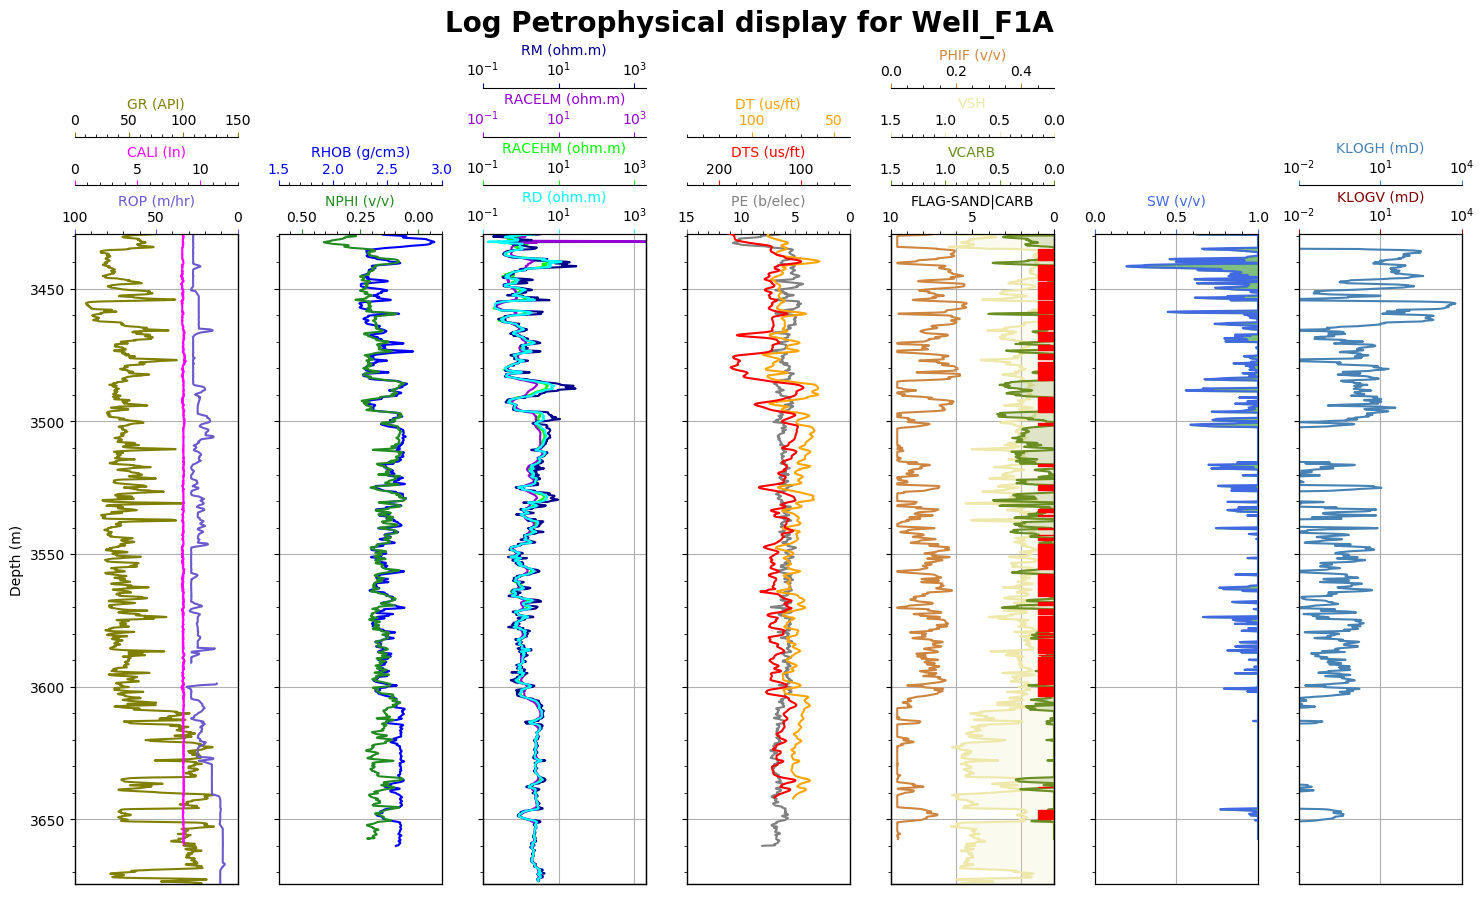

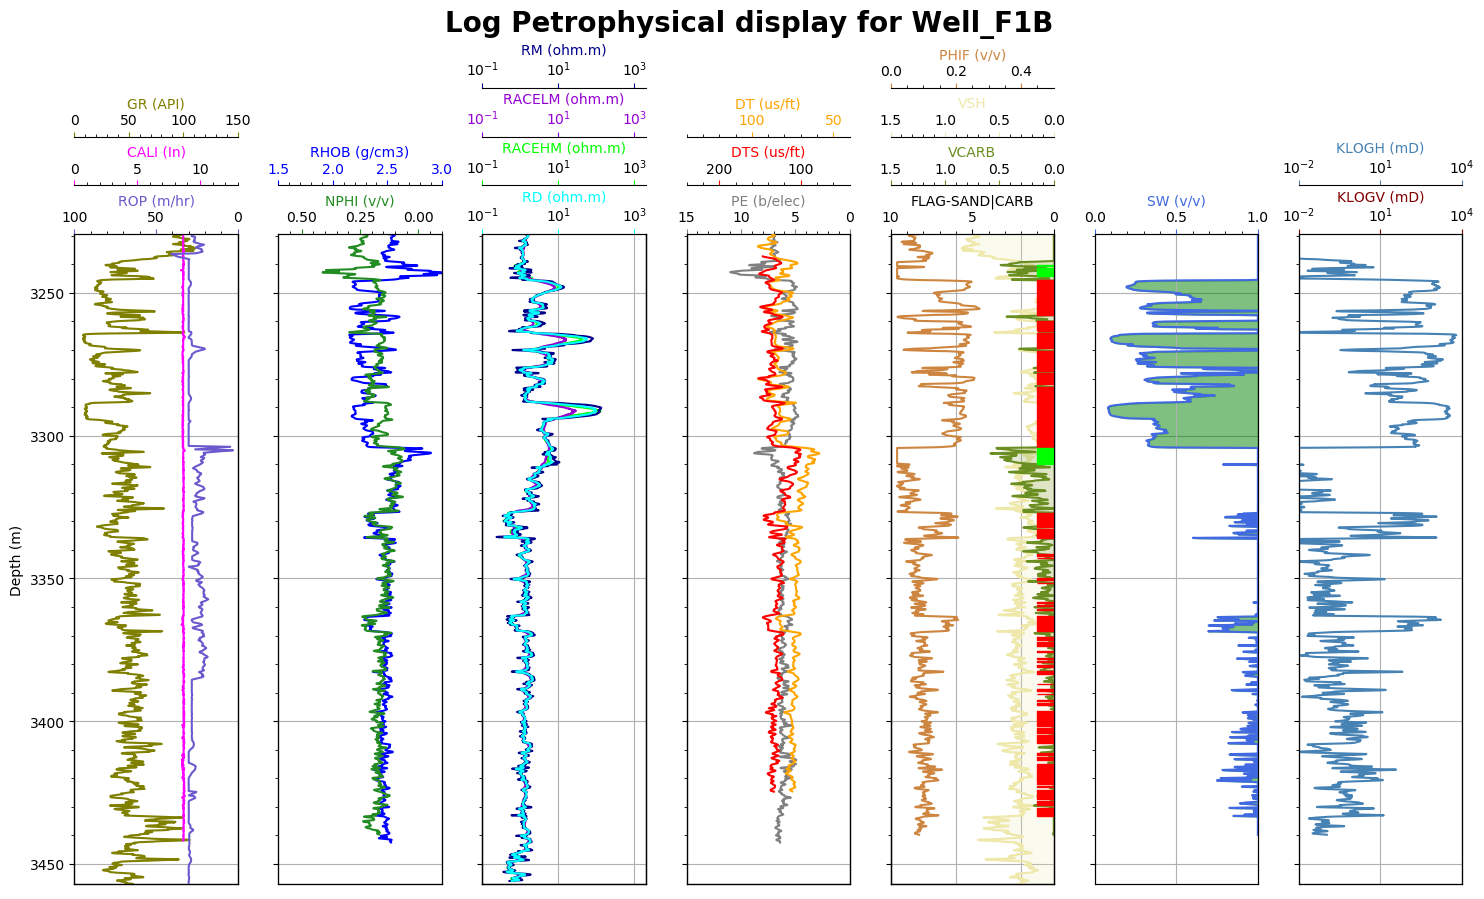

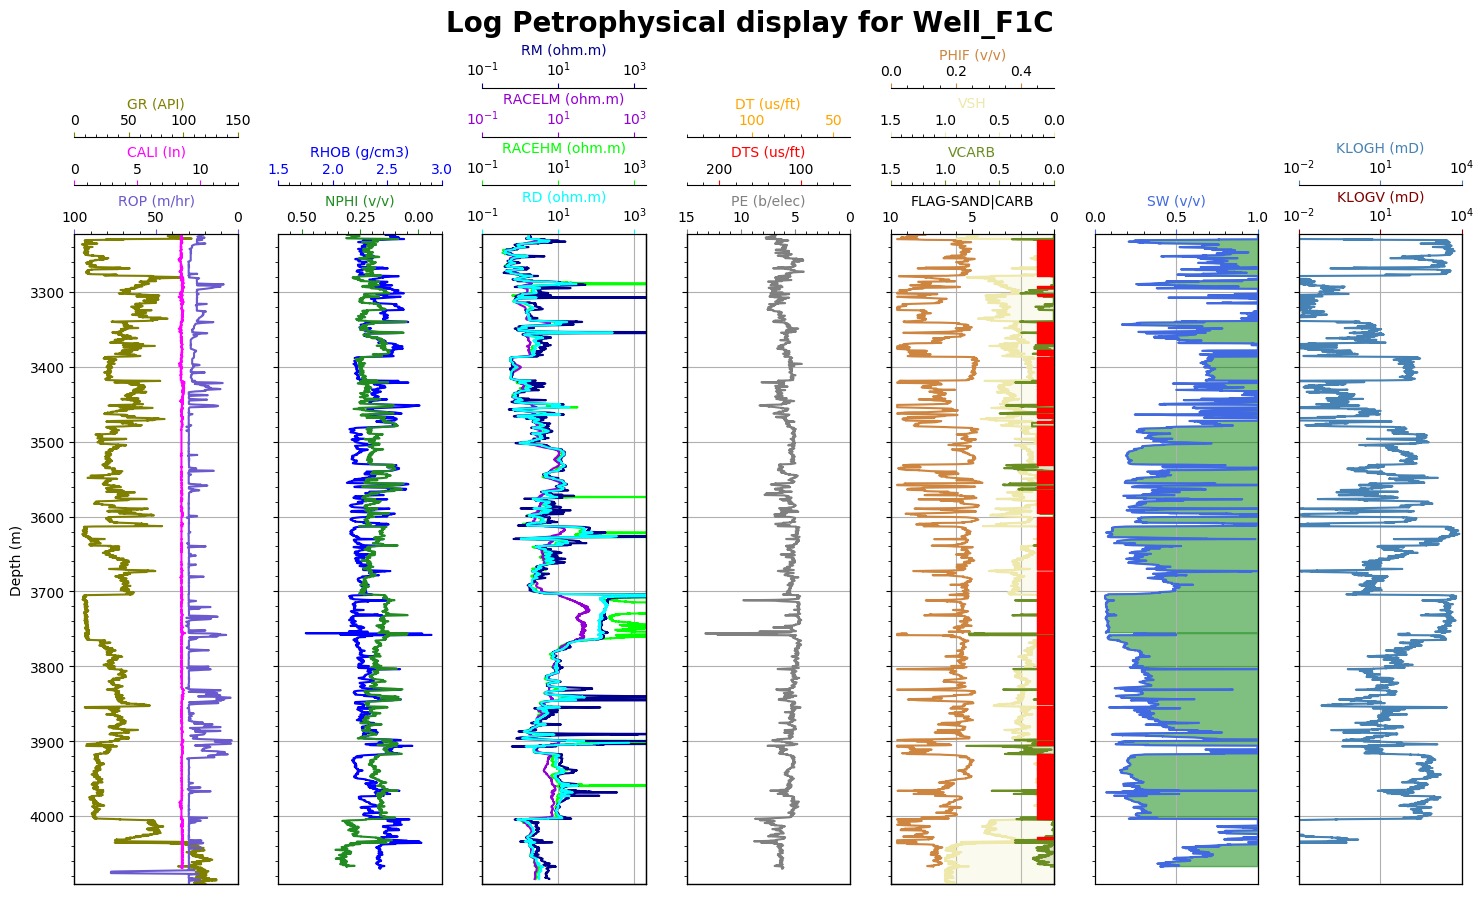

In [60]:
# generate plots for next three wells

for well in n_wells[3:6]:
    well_name=data_final[data_final['WELL_NAME'] == '%s' % well]
    well_log_plot (well_name,depths=['TOP','BOTTOM'])

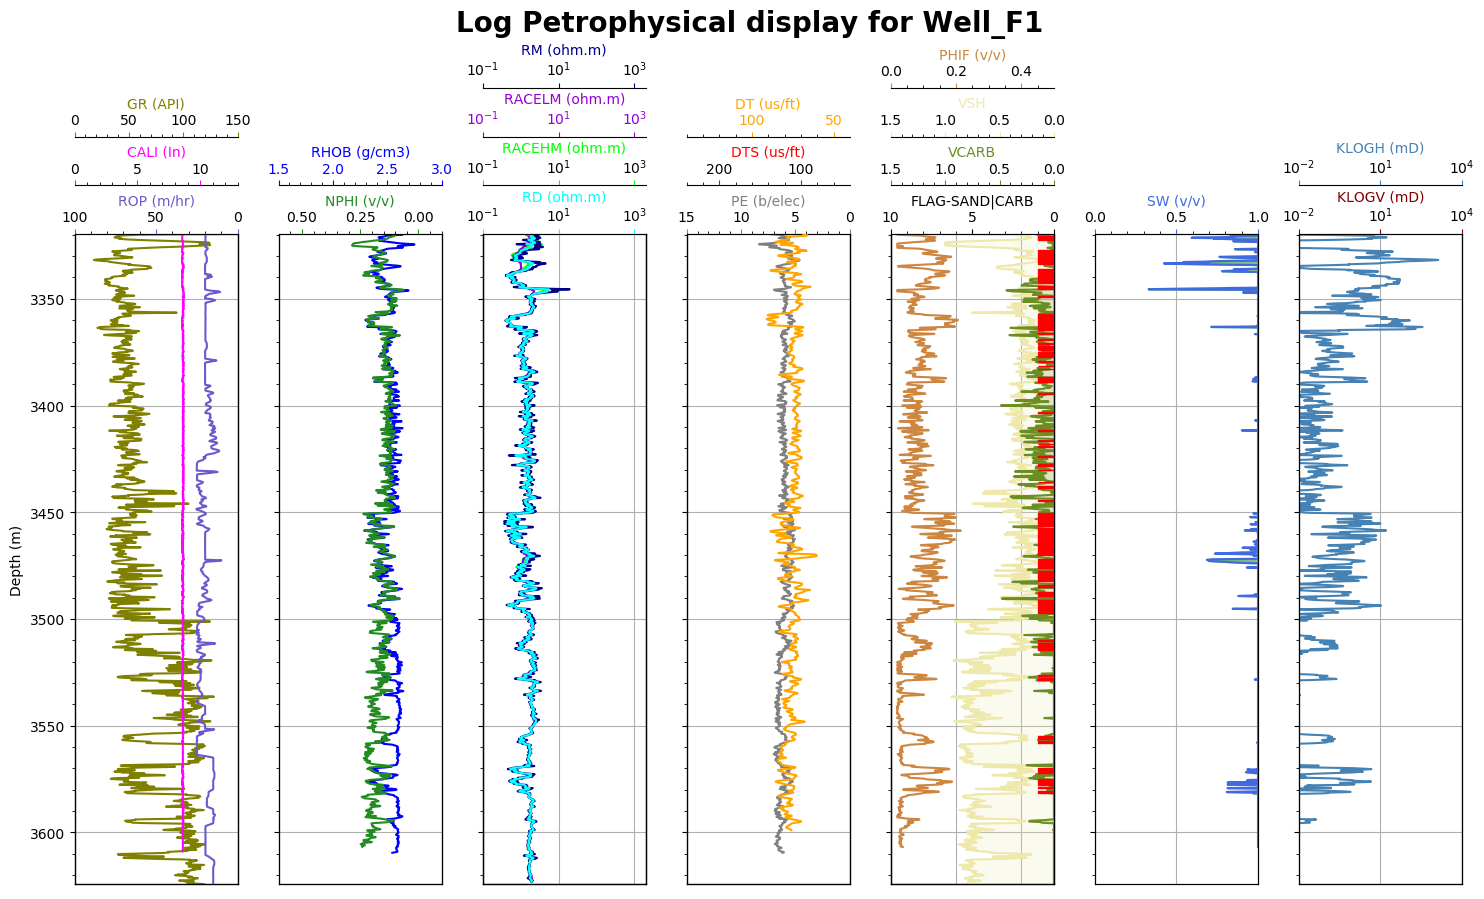

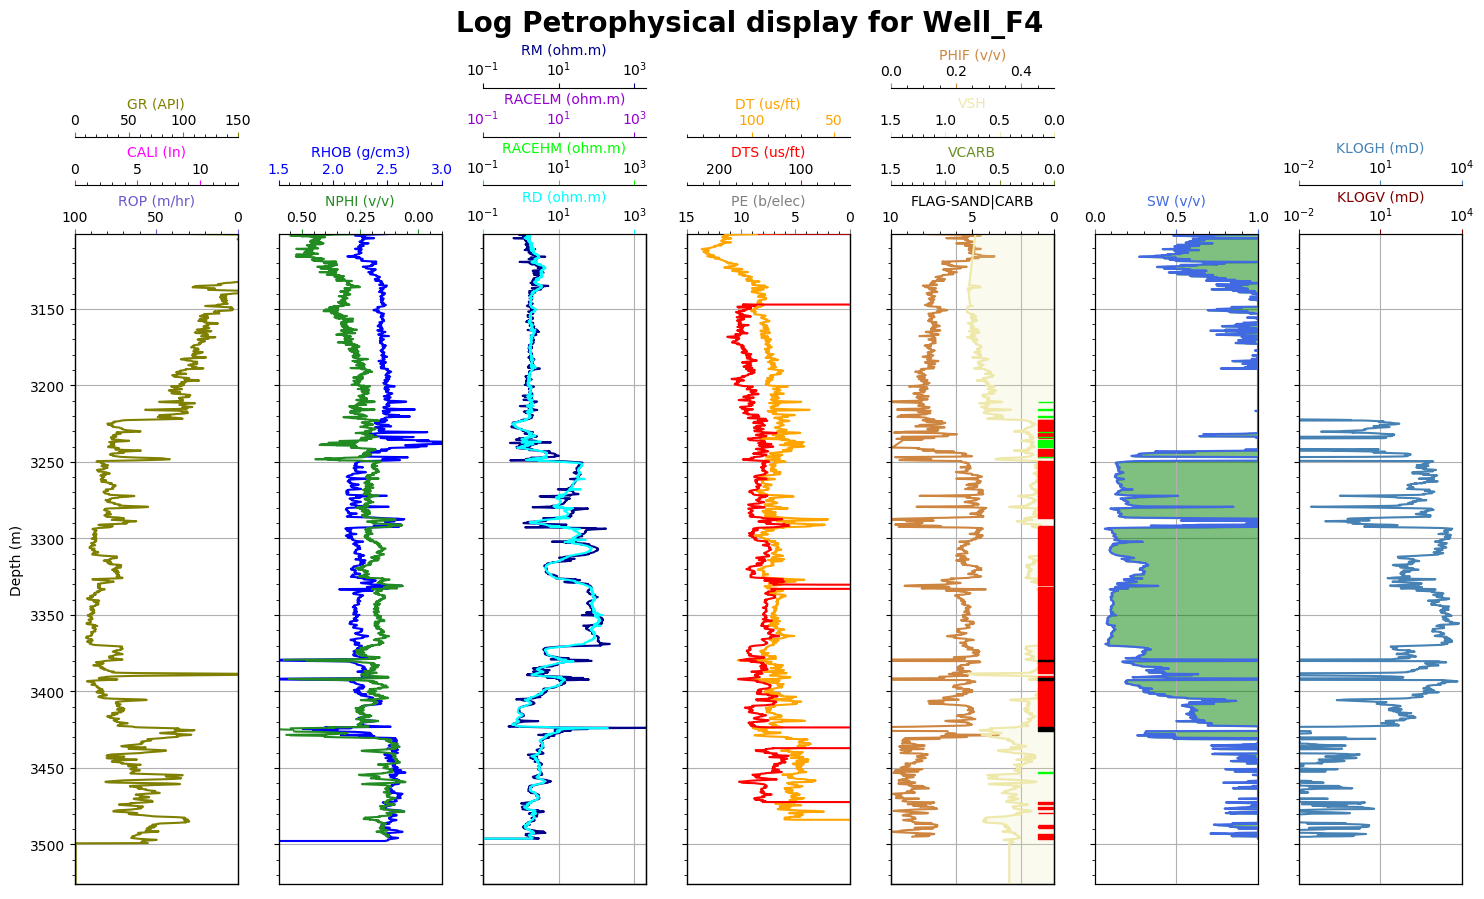

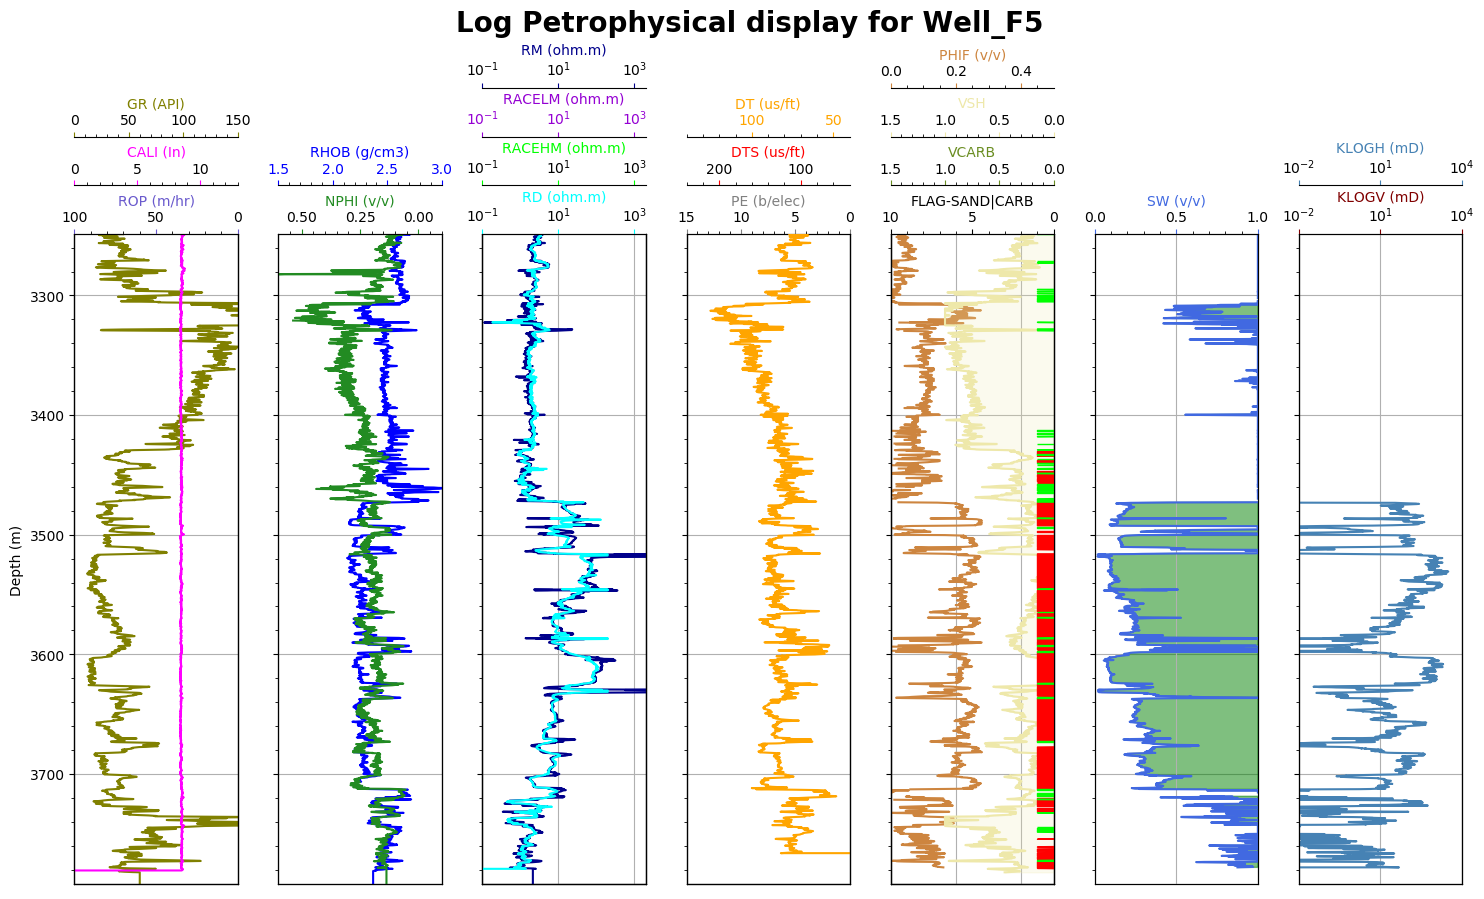

In [61]:
# generate plots for next three wells

for well in n_wells[6:9]:
    well_name=data_final[data_final['WELL_NAME'] == '%s' % well]
    well_log_plot (well_name,depths=['TOP','BOTTOM'])

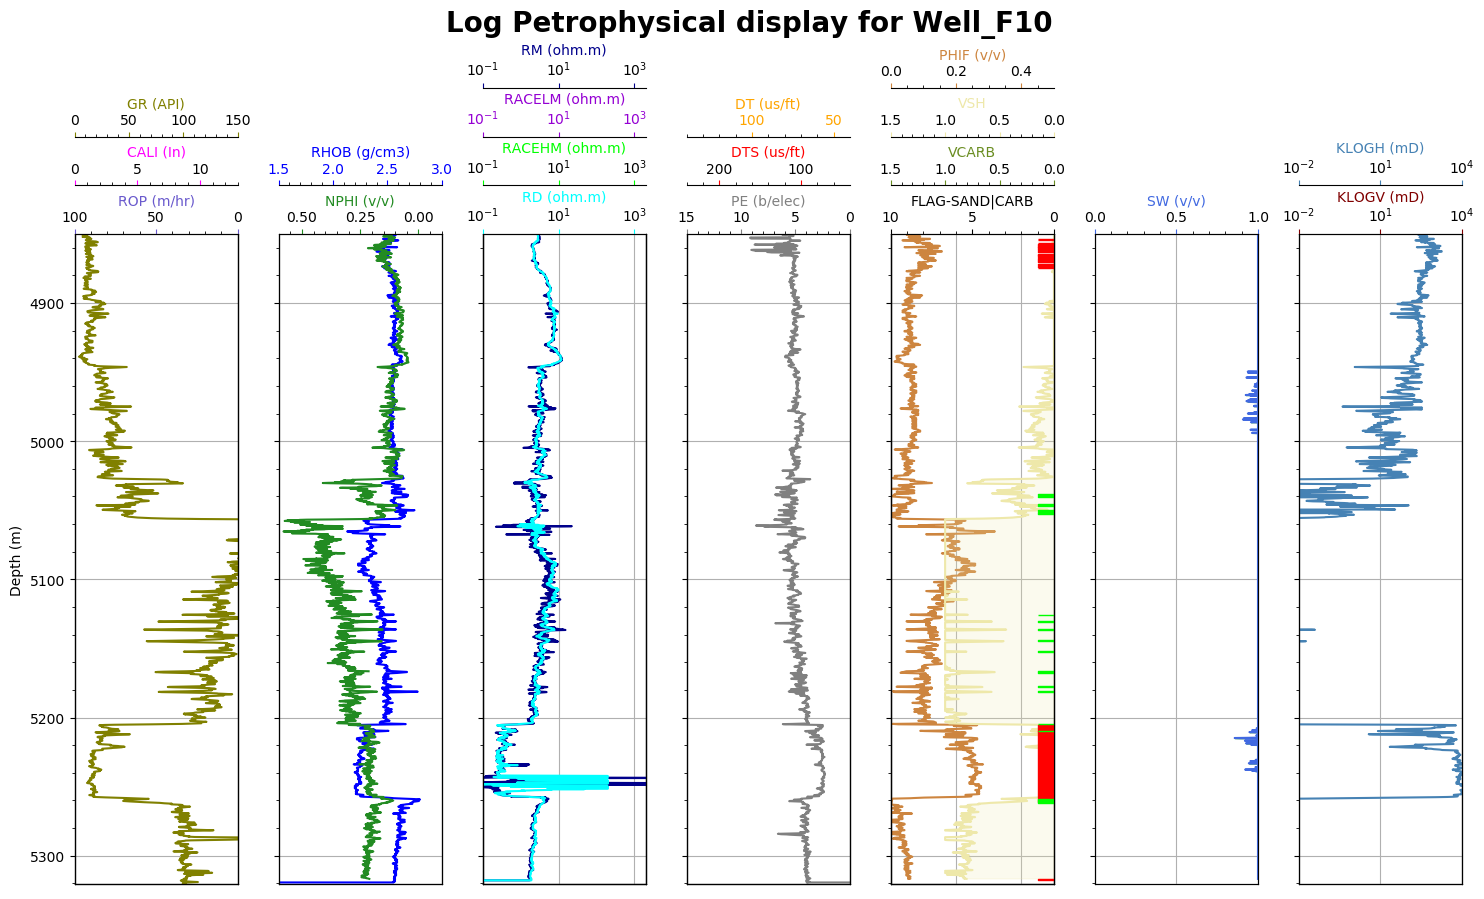

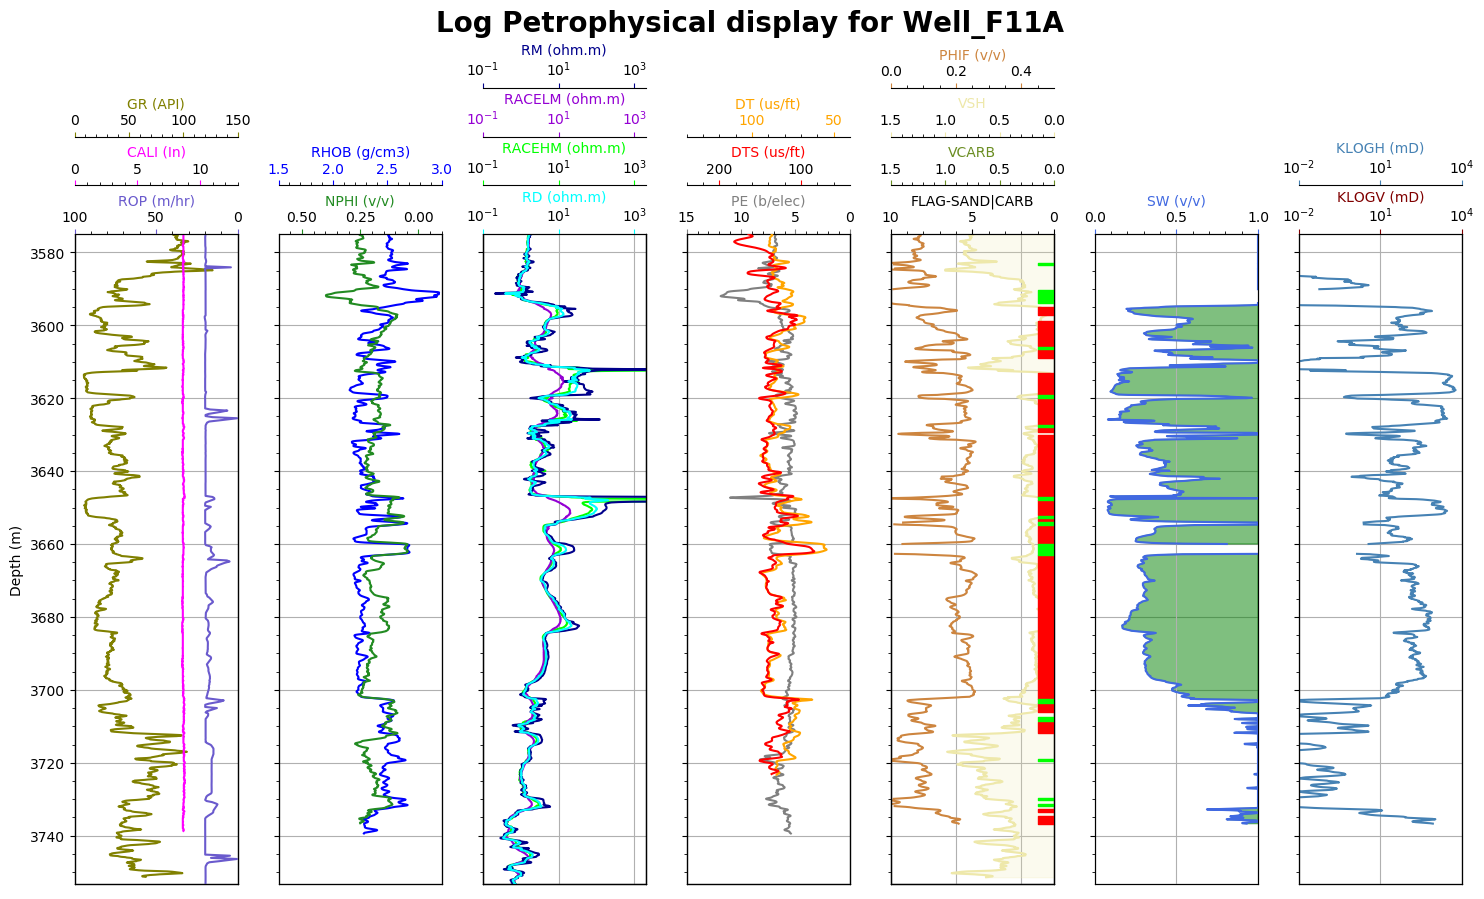

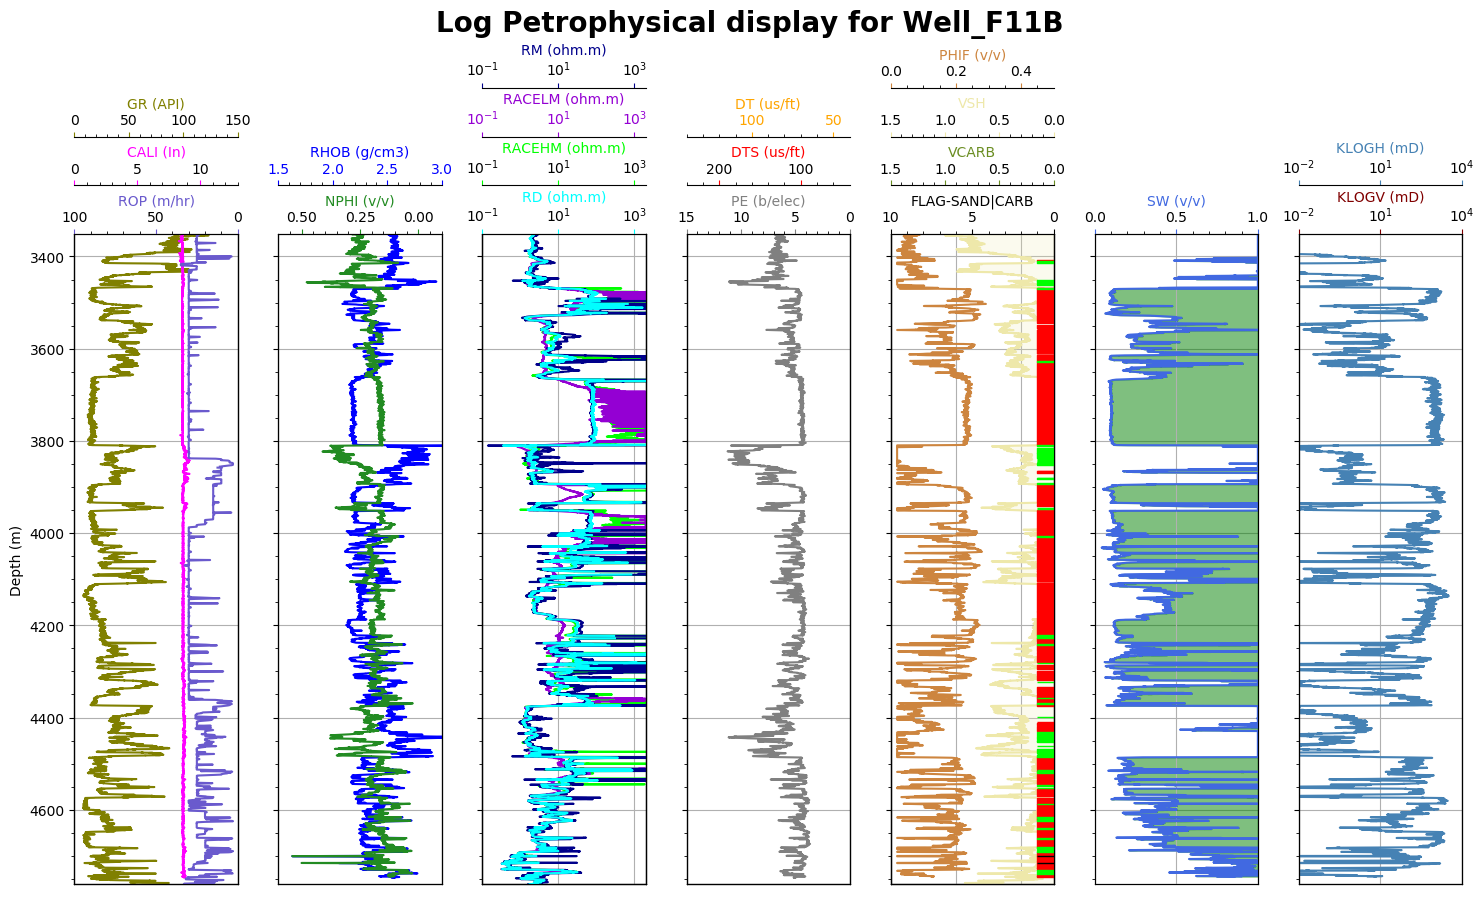

In [62]:
# generate plots for next three wells

for well in n_wells[9:12]:
    well_name=data_final[data_final['WELL_NAME'] == '%s' % well]
    well_log_plot (well_name,depths=['TOP','BOTTOM'])

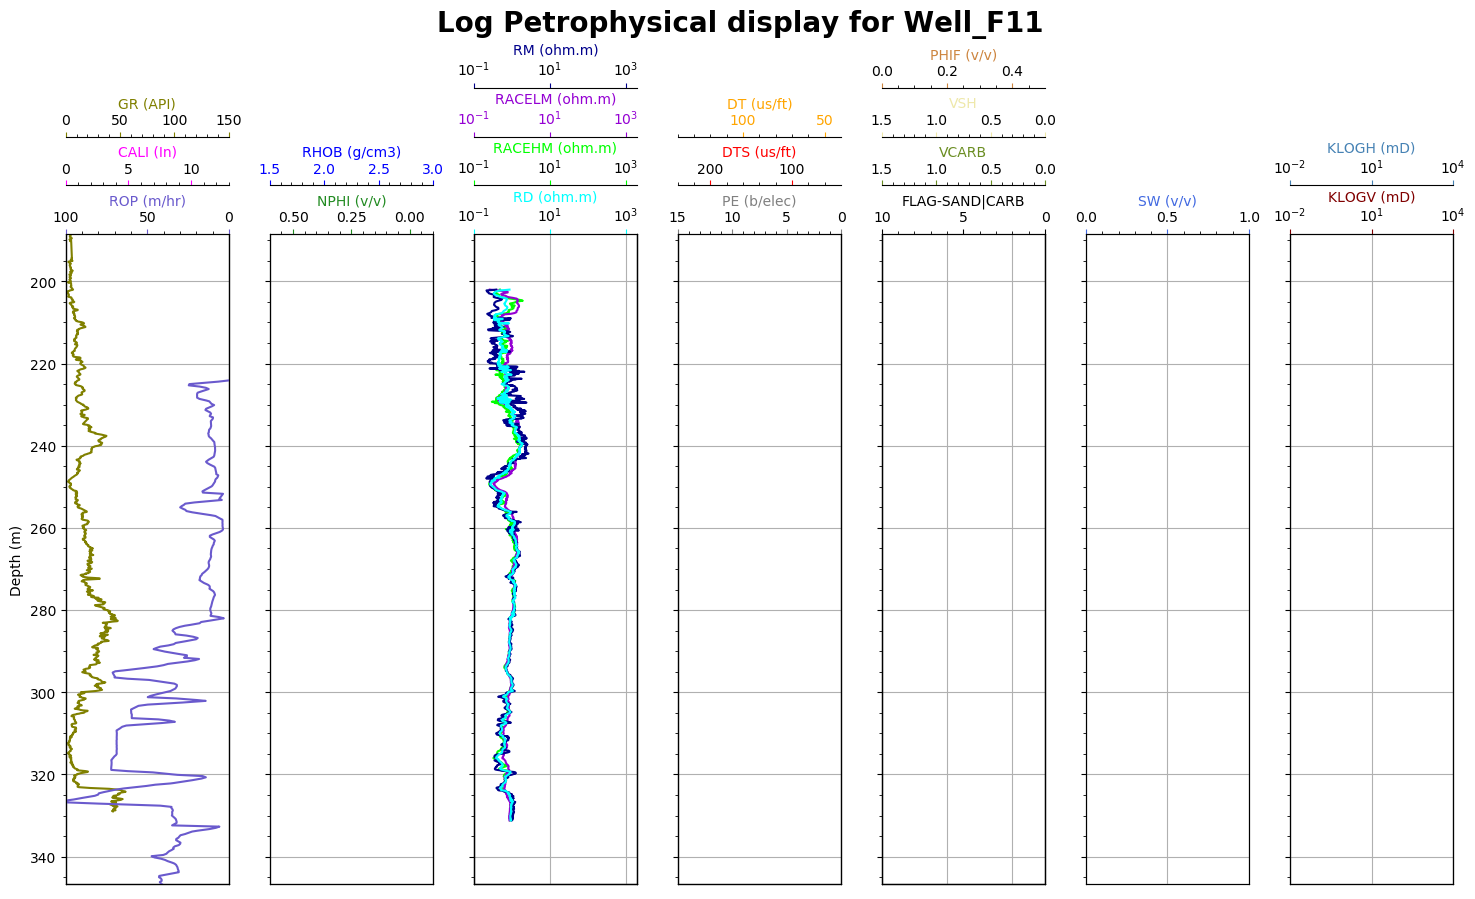

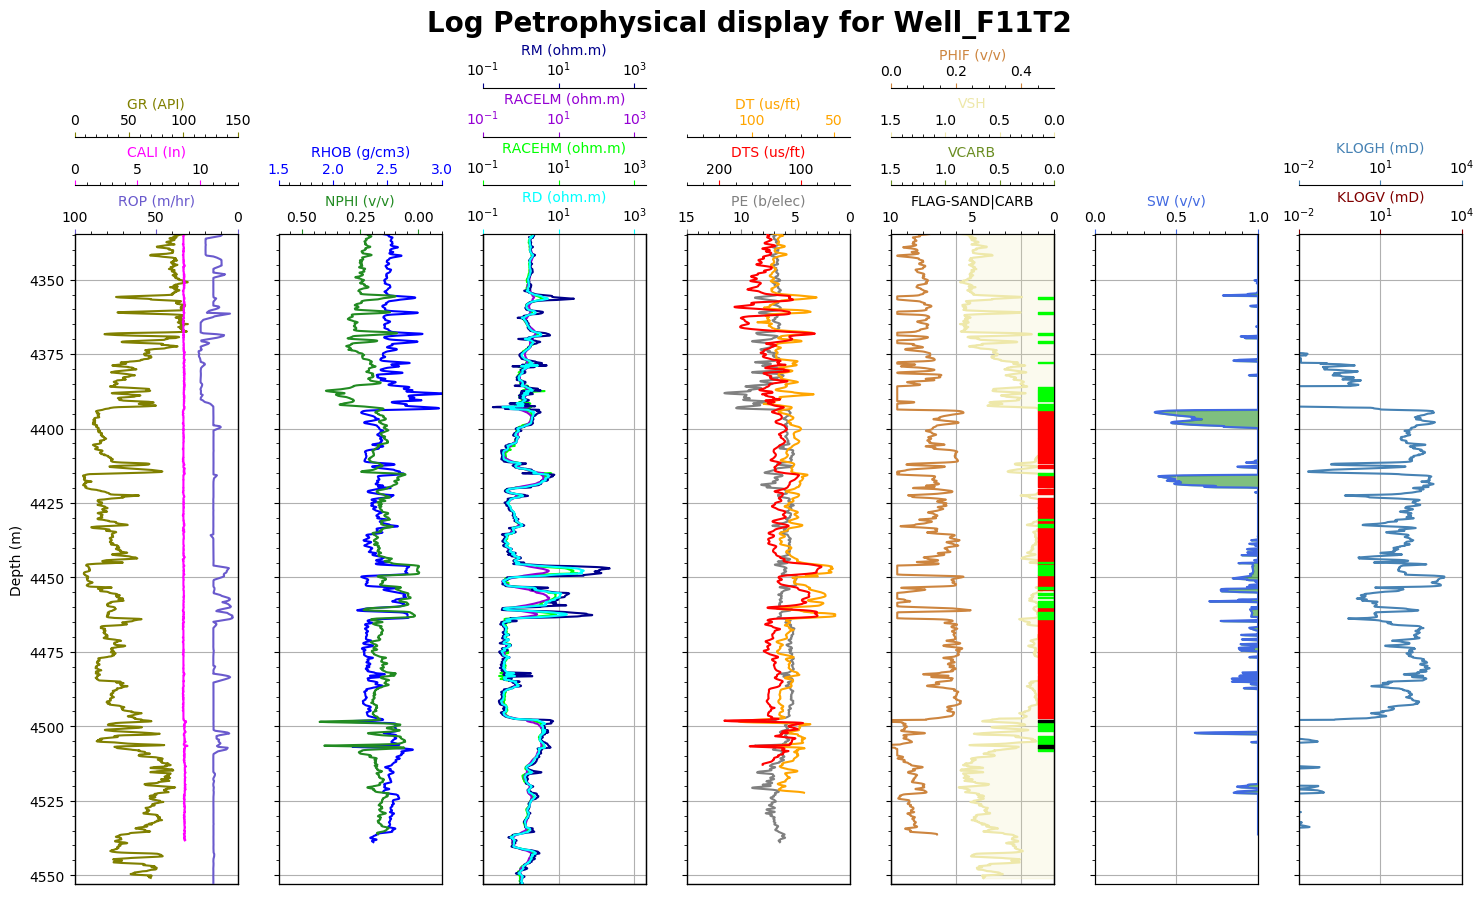

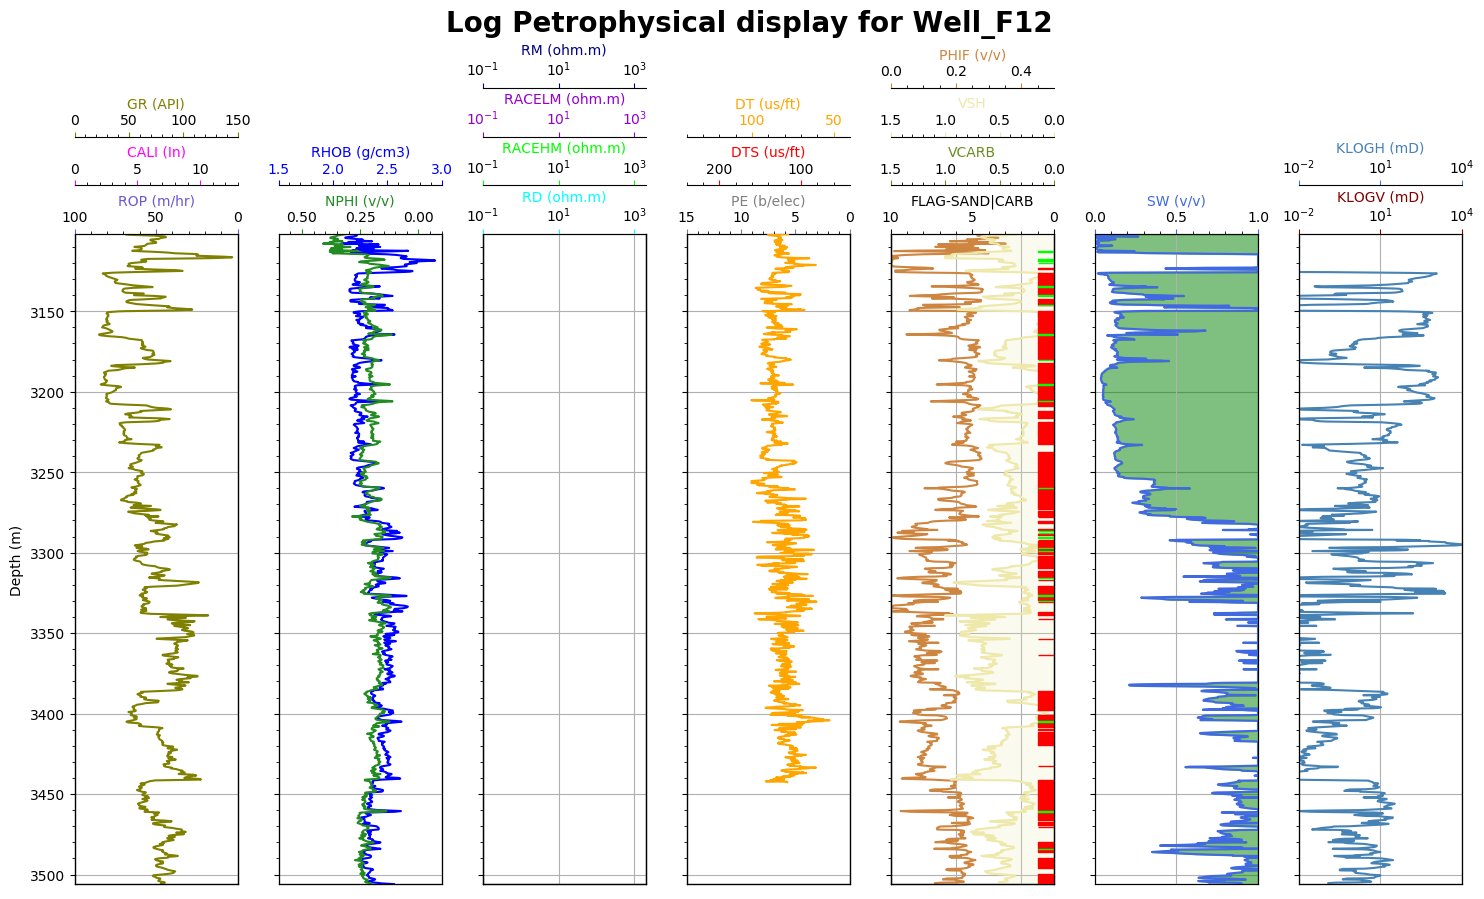

In [96]:
# generate plots for next three wells

for well in n_wells[12:15]:
    well_name=data_final[data_final['WELL_NAME'] == '%s' % well]
    well_log_plot (well_name,depths=['TOP','BOTTOM'])

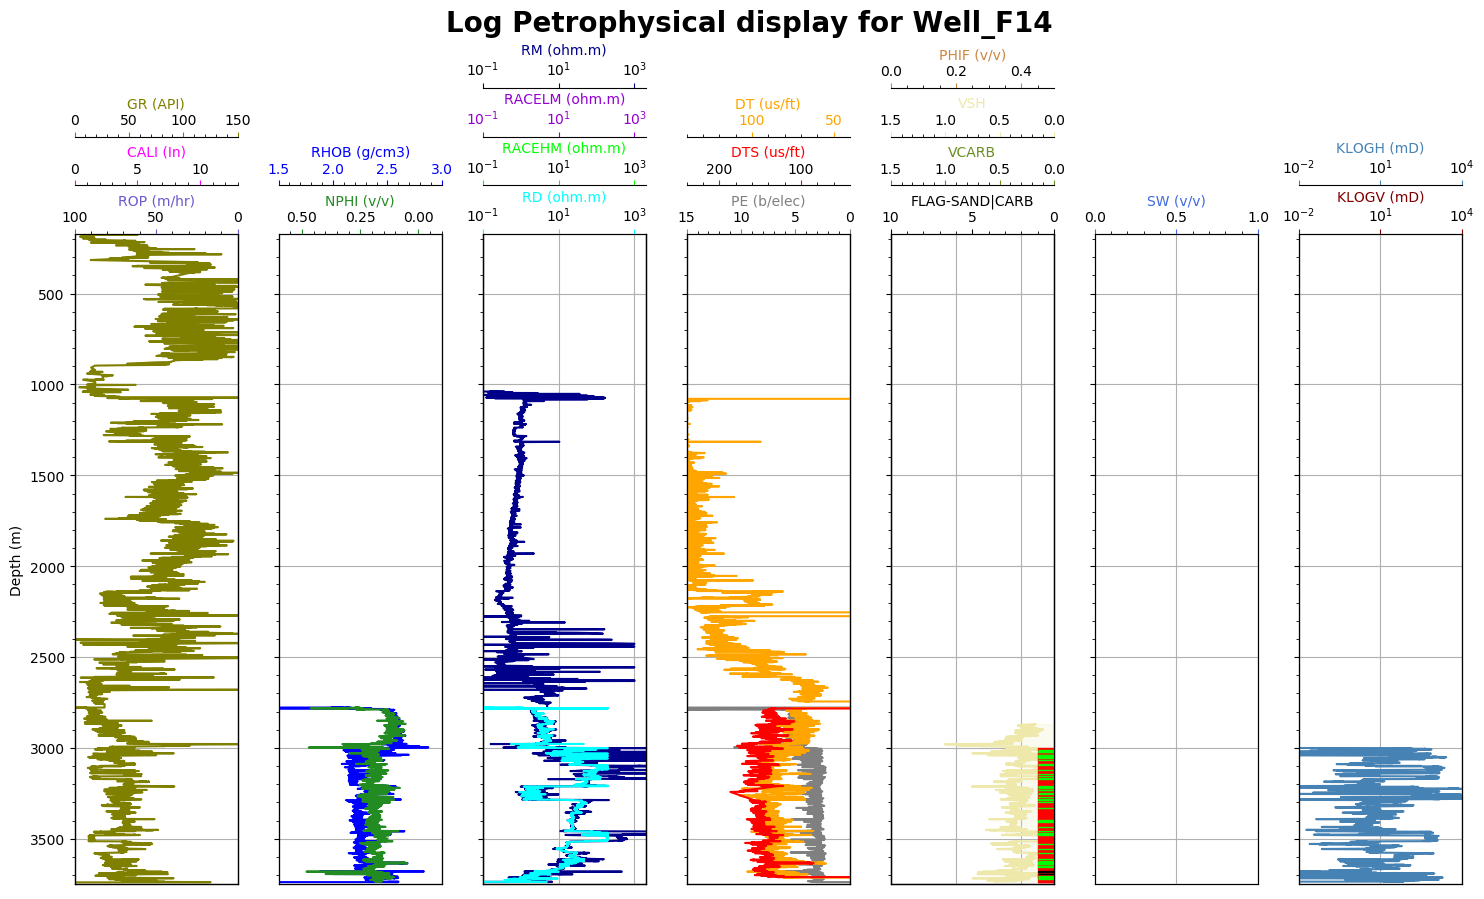

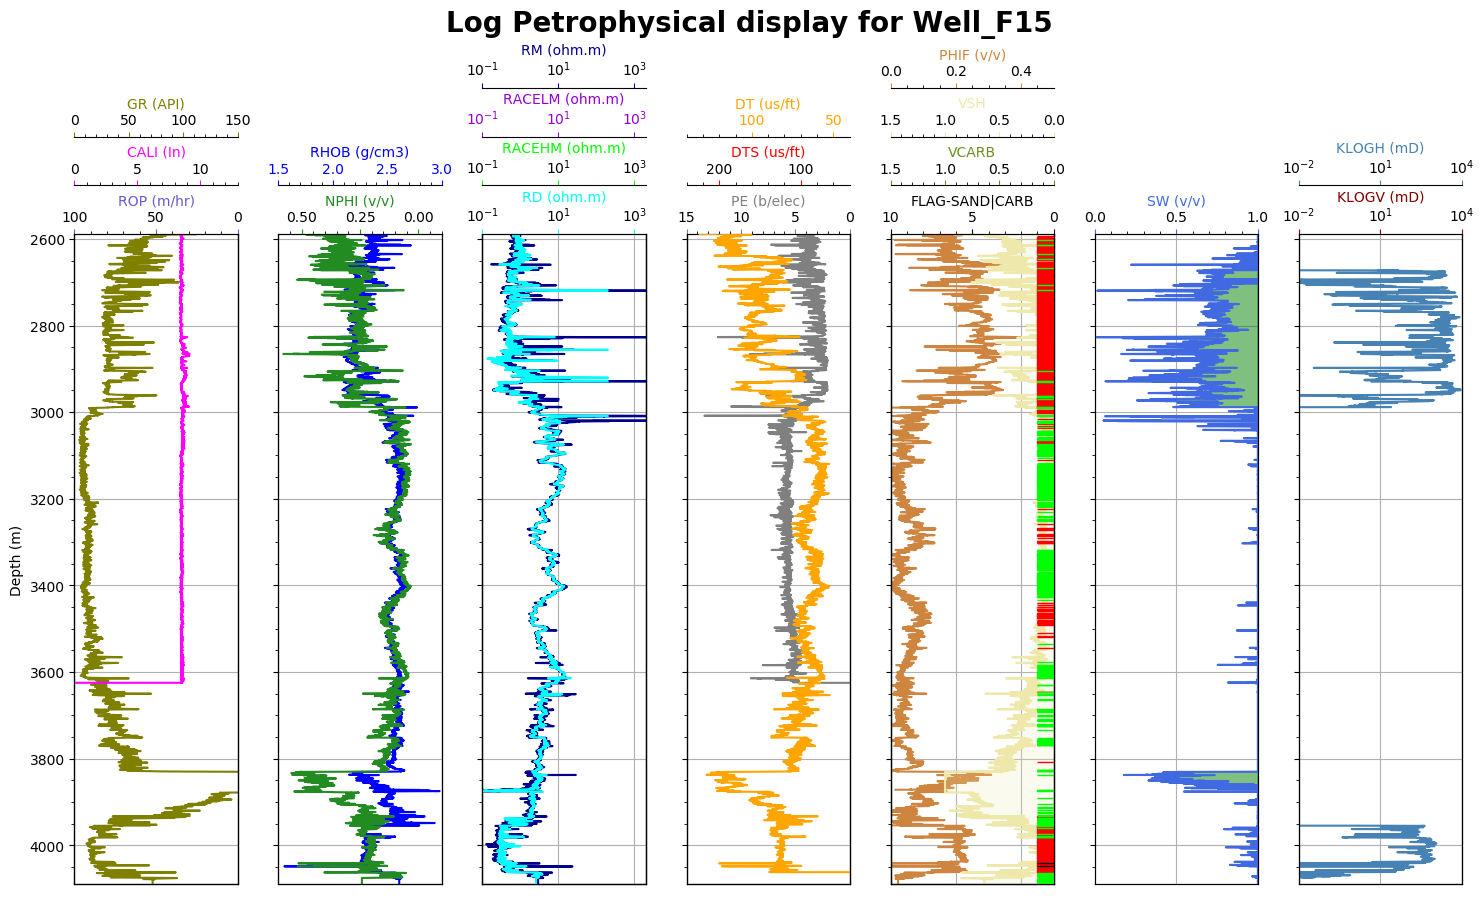

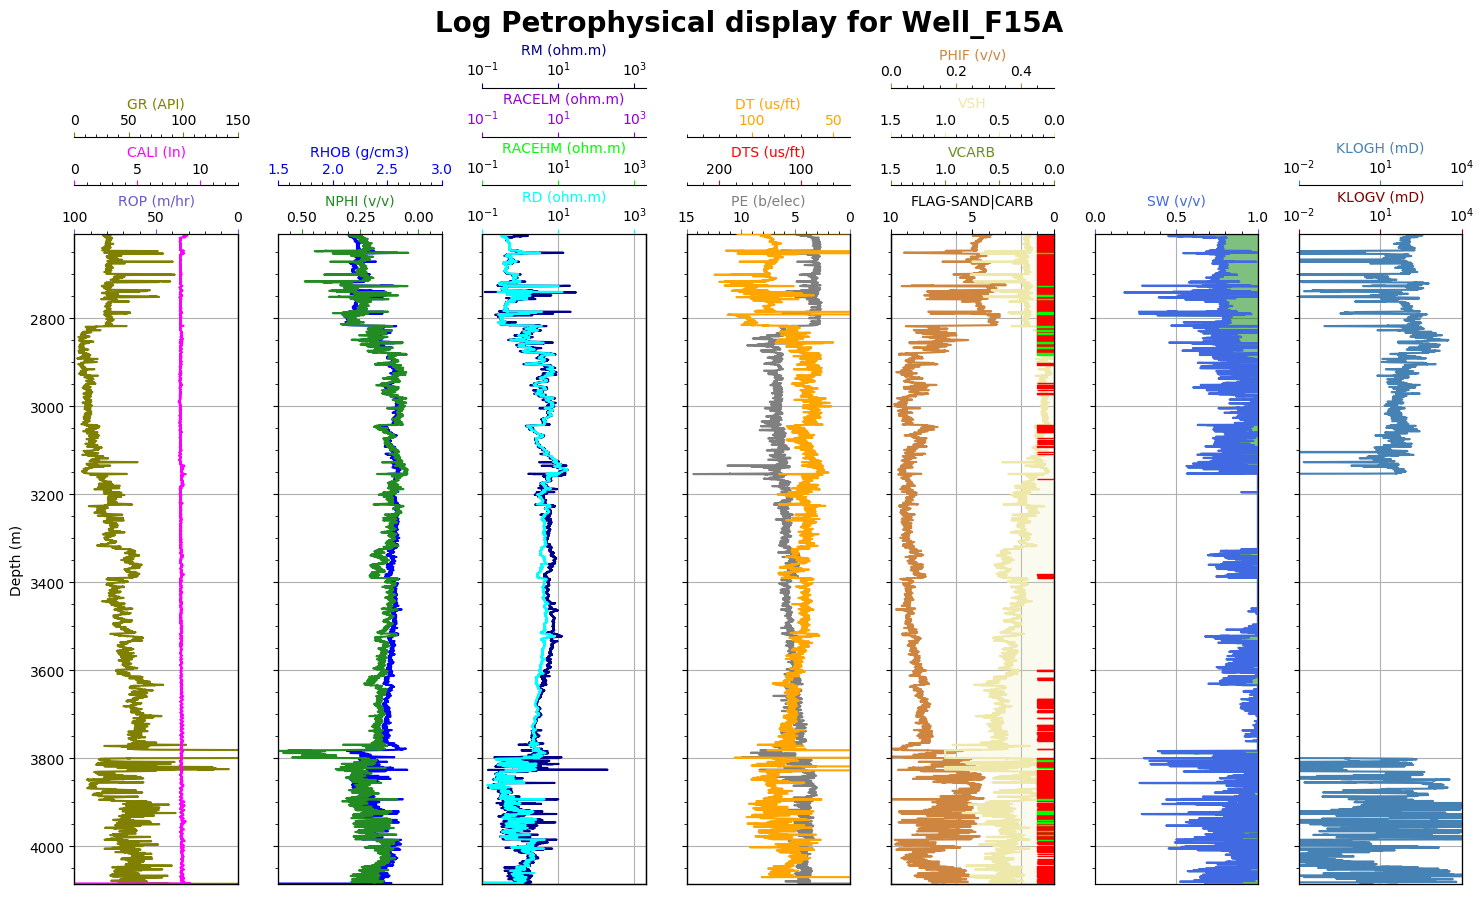

In [98]:
# generate plots for next three wells

for well in n_wells[15:18]:
    well_name=data_final[data_final['WELL_NAME'] == '%s' % well]
    well_log_plot (well_name,depths=['TOP','BOTTOM'])

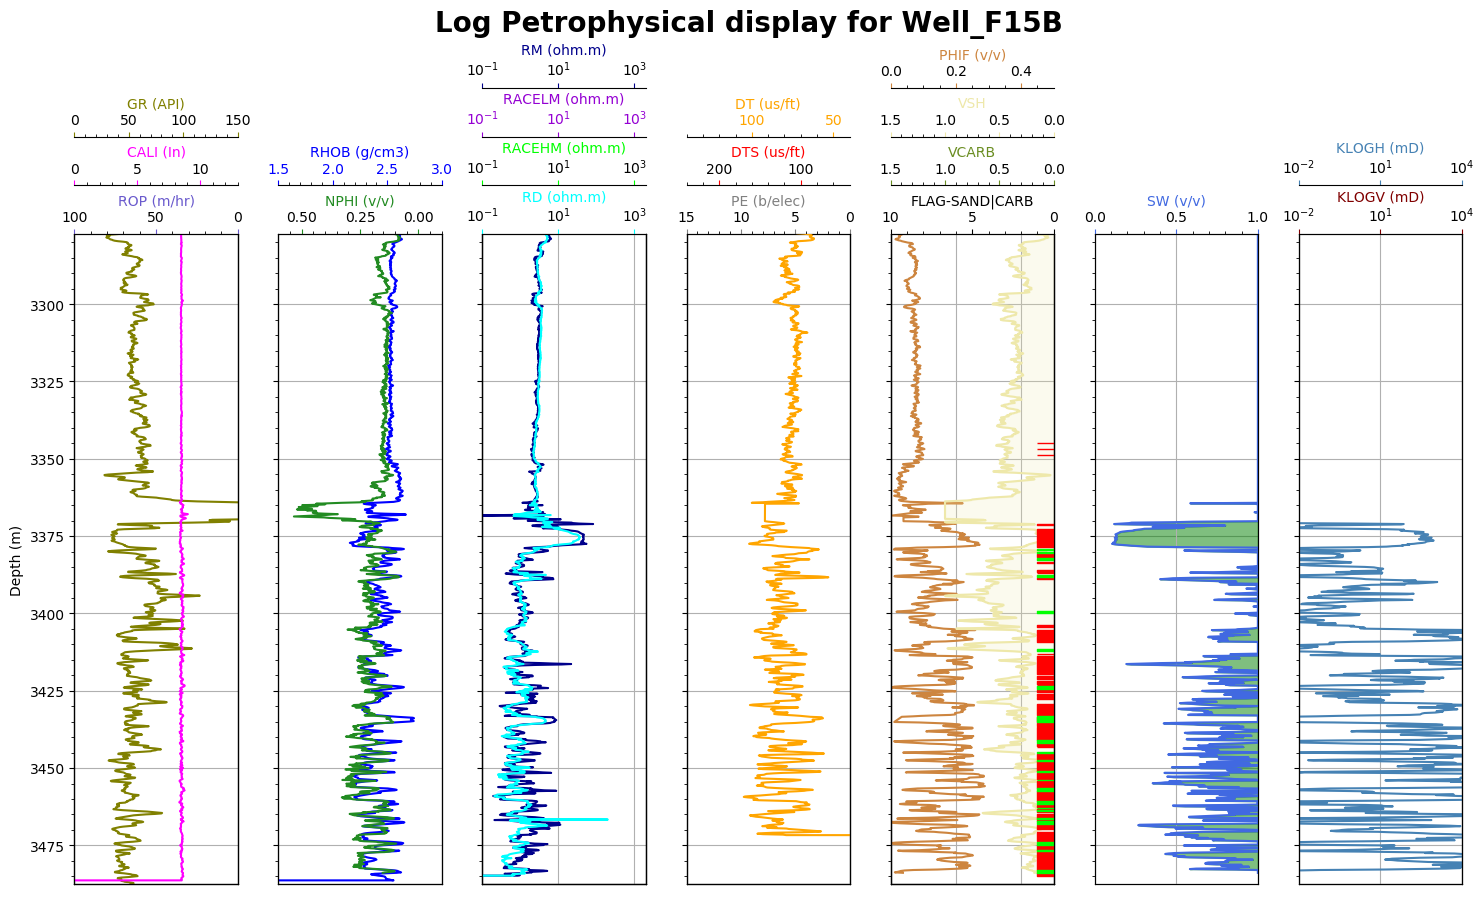

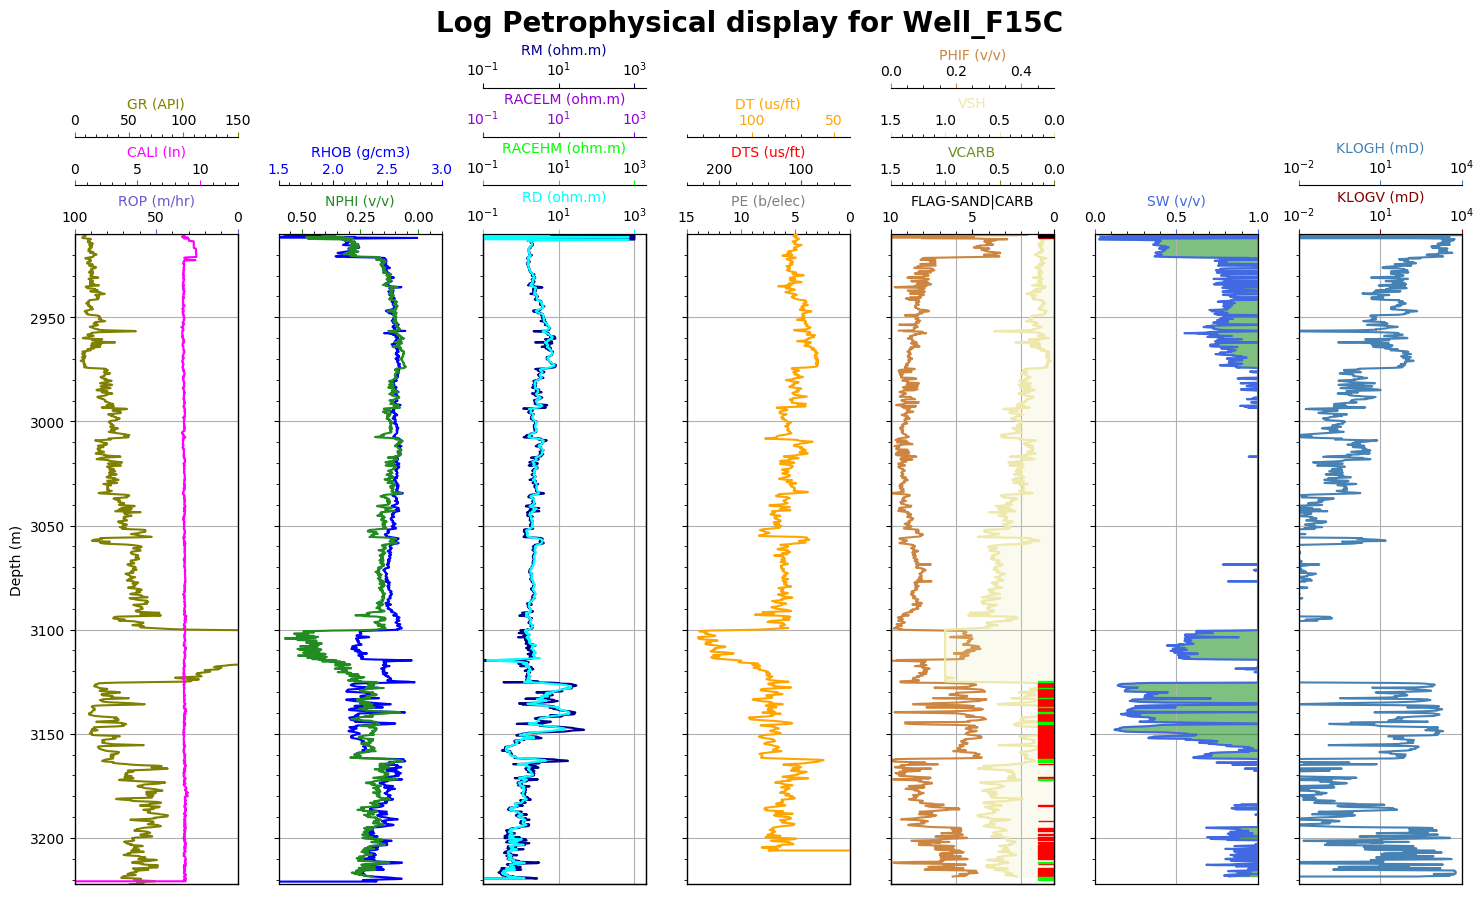

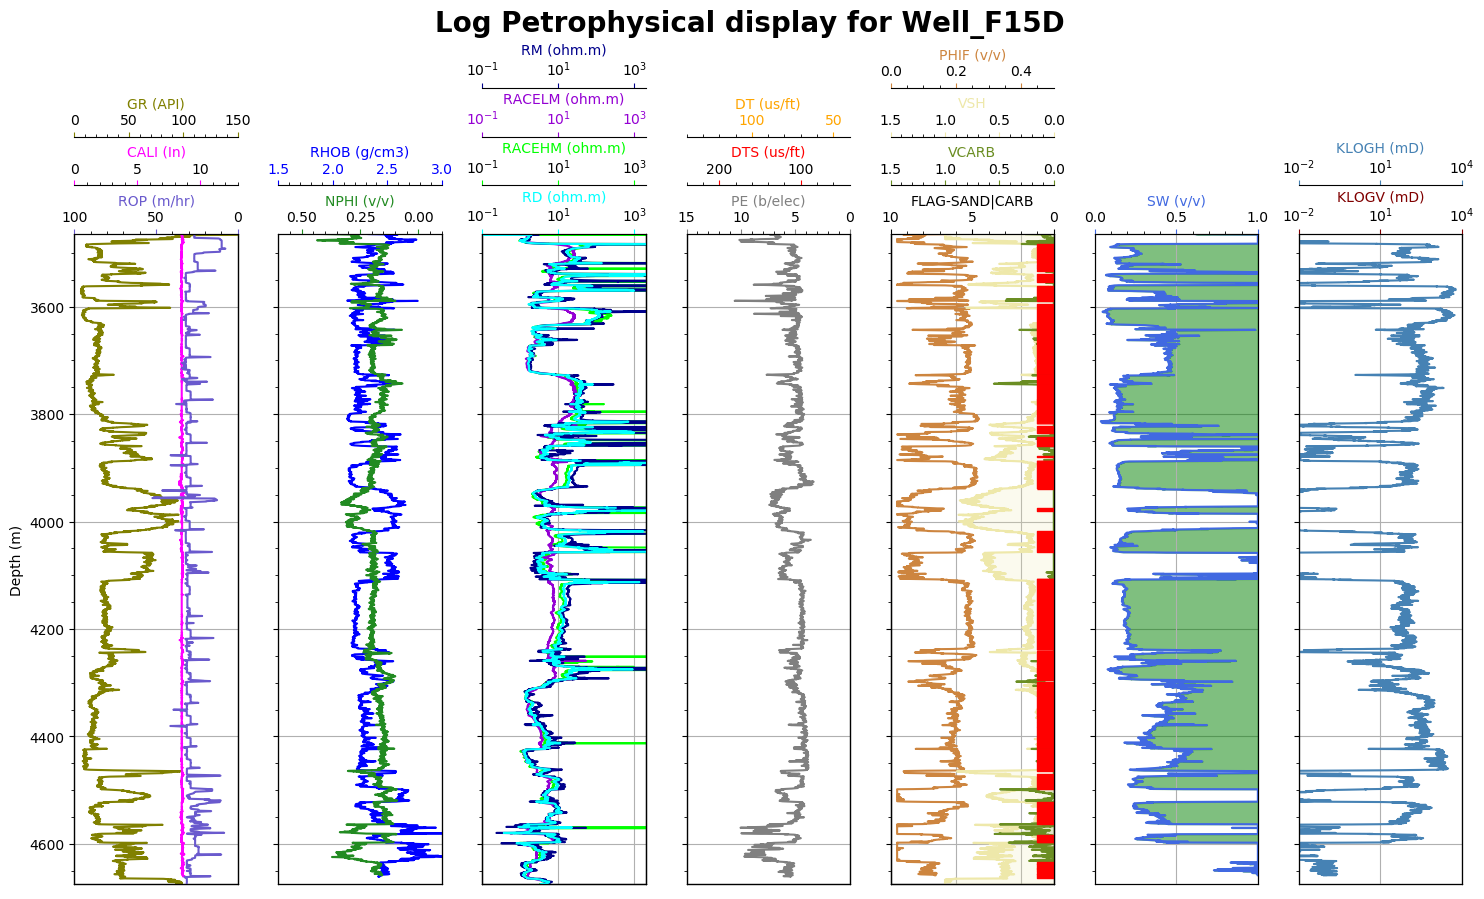

In [72]:
# generate plots for next three wells

for well in n_wells[18:]:
    well_name=data_final[data_final['WELL_NAME'] == '%s' % well]
    well_log_plot (well_name,depths=['TOP','BOTTOM'])

`combined`合并后的`well data`井筒数据被导出`exported`为 CSV 文件，用于`prediction`预测页岩体积含量 (VShale)、声波时差 (DT)、孔隙度 (PHI)、含水饱和度 (SW) 和渗透率 (PERM)。

## 额外解释

### 链式索引 Chain indexing

用于配置Pandas库的选项，以完全抑制链式索引警告。Pandas是一个用于数据分析和操作的Python库，它提供了DataFrame和Series等数据结构，用于处理和分析数据。

在Pandas中，链式索引是指在一个操作后立即进行另一个操作，例如：

```python
df['column_name'][0] = new_value
```

这种操作方式在某些情况下可能会导致性能问题，因为它可能会创建不必要的中间对象。此外，由于这种操作方式可能会导致数据的意外修改，Pandas会发出警告。

`pd.set_option('mode.chained_assignment', None)`这行代码的作用是设置Pandas的选项，使得在进行链式索引操作时不发出警告。这样做可以帮助开发者在不需要警告的情况下进行链式索引操作，但是需要注意的是，这并不意味着链式索引操作是安全的，开发者仍需要确保自己的操作不会导致数据的意外修改。

这是一个示例，展示了如何使用这个选项：

```python
import pandas as pd

#  设置选项，抑制链式索引警告
pd.set_option('mode.chained_assignment', None)

#  创建一个简单的DataFrame
df = pd.DataFrame({'A': [1,  2,  3], 'B': [4,  5,  6]})

#  使用链式索引修改数据，不会发出警告
df['A'][0] =  10

print(df)
```

输出：

```
    A  B
0   10   4
1   2   5
2   3   6
```

这段代码首先设置了Pandas的选项，然后创建了一个简单的DataFrame，并使用链式索引修改了其中的一个值。由于设置了抑制链式索引警告的选项，所以这个操作不会发出警告。